# Load Data

In [1]:
'''
This script optimizes logistic nonlinearities for a variety of Gaussian distribtuions and plots the optimal parameters.
Author: Jonathan Gant
Date: 29.08.2024
'''

import numpy as np
import matplotlib.pyplot as plt
from utilities import logistic_func, calc_MI, calc_entropy
from tqdm import tqdm
import h5py
import os
import bottleneck as bn

# Set random seed for reproducibility
np.random.seed(0)

# load in the data
# all_gabor_responses = h5py.File('../results/new_nat_videos_gabor_responses_full_res_z_score.h5', 'r')
all_gabor_responses = h5py.File('../results/new_nat_videos_gabor_responses_full_res_z_score_more_freq.h5', 'r')
# all_gabor_responses_low_freq = h5py.File('../results/new_nat_videos_gabor_responses_full_res_more_low_freq_z_score.h5', 'r')
# all_gabor_responses_eye_movements = h5py.File('../results/new_nat_videos_gabor_responses_full_res_more_low_freq_z_score_eye_movements.h5', 'r')
# all_gabor_responses_eye_movements_long = h5py.File('../results/new_nat_videos_gabor_responses_full_res_more_low_freq_z_score_eye_movements_2s_interval_stat_only.h5', 'r')

# all_gabor_responses = h5py.File('../results/new_nat_vids_gabor_responses_full_res.h5', 'r')

# video size
resolution_height = 1080
resolution_width = 1920

# fov
horizontal_fov = 92
vertical_fov = 61

# conversion factor of pixels to degrees
horizontal_pixels_per_degree = resolution_width / horizontal_fov
vertical_pixels_per_degree = resolution_height / vertical_fov

# average of the conversion factors to the nearest integer
pixels_per_degree = np.ceil((horizontal_pixels_per_degree + vertical_pixels_per_degree) / 2)
print(pixels_per_degree)

# data hyperparameters
orientation_arr = all_gabor_responses['orientation_arr'][()]
phase_arr = all_gabor_responses['phase_arr'][()]
position_arr = all_gabor_responses['position_arr'][()]
wavelength_arr = all_gabor_responses['wavelength_arr'][()]
# wavelength_arr_low_freq = all_gabor_responses_low_freq['wavelength_arr'][()]
freq_arr = pixels_per_degree / wavelength_arr
# freq_arr_low_freq = pixels_per_degree / wavelength_arr_low_freq
filter_size = (resolution_height, resolution_width)
print(freq_arr)
low_spatial_freq_idx = np.arange(0, 31)
high_spatial_freq_idx = np.arange(35, 70)

20.0
[0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13 0.14 0.15
 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27 0.28 0.29
 0.3  0.31 0.32 0.33 0.34 0.35 0.36 2.   2.12 2.24 2.36 2.48 2.6  2.72
 2.84 2.96 3.08 3.2  3.32 3.44 3.56 3.68 3.8  3.92 4.04 4.16 4.28 4.4
 4.52 4.64 4.76 4.88 5.   5.12 5.24 5.36 5.48 5.6  5.72 5.84 5.96 6.08]


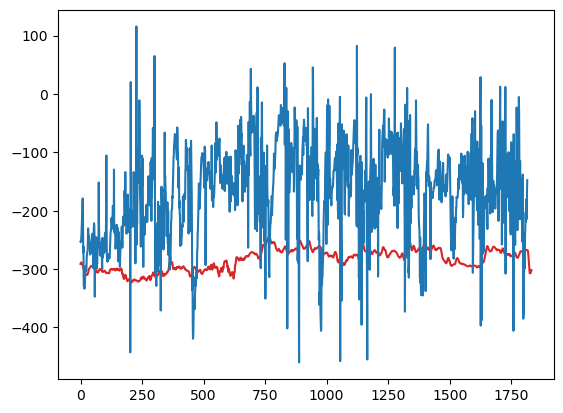

In [2]:
plt.plot(all_gabor_responses['field']['stationary_1'][0, 0, 0, 4, :], color='tab:red')
plt.plot(all_gabor_responses['field']['moving_1'][0, 0, 0, 4, :], color='tab:blue')

# Temporal filtering

## Load and average PSD

In [3]:
# parse the data and compute fourier transform for each filter and video
environments = ['field', 'forest', 'orchard', 'tall_grass', 'pond']

num_videos = 10
vid_length = 50*30
low_spatial_freq_idx = np.arange(0, 31)
# low_spatial_freq_idx = np.arange(0, 19)
# high_spatial_freq_idx = np.arange(35, 70)
# low_spatial_freq_idx = np.arange(35, 70)

stationary_stim = np.zeros((len(environments), num_videos, len(orientation_arr), len(phase_arr), len(low_spatial_freq_idx), len(position_arr), vid_length))
moving_stim = np.zeros((len(environments), num_videos, len(orientation_arr), len(phase_arr), len(low_spatial_freq_idx), len(position_arr), vid_length))

# get the responses for each environment
for i, env_key in enumerate(environments):
    stationary_count = 0
    moving_count = 0
    all_gabor_responses_env = all_gabor_responses[env_key]
    print(all_gabor_responses_env.keys())
    for vid_key in all_gabor_responses_env.keys():
        if 'stationary' in vid_key:
            stationary_stim[i, stationary_count, :, :, :, :, :] = all_gabor_responses_env[vid_key][()][:, :, low_spatial_freq_idx, :, :vid_length]
            stationary_count += 1
        if 'moving' in vid_key and 'free_moving' not in vid_key:
            moving_stim[i, moving_count, :, :, :, :, :] = all_gabor_responses_env[vid_key][()][:, :, low_spatial_freq_idx, :, :vid_length]
            moving_count += 1

<KeysViewHDF5 ['free_moving_1', 'free_moving_10', 'free_moving_2', 'free_moving_3', 'free_moving_4', 'free_moving_5', 'free_moving_6', 'free_moving_7', 'free_moving_8', 'free_moving_9', 'moving_1', 'moving_10', 'moving_2', 'moving_3', 'moving_4', 'moving_5', 'moving_6', 'moving_7', 'moving_8', 'moving_9', 'stationary_1', 'stationary_10', 'stationary_2', 'stationary_3', 'stationary_4', 'stationary_5', 'stationary_6', 'stationary_7', 'stationary_8', 'stationary_9']>


KeyboardInterrupt: 

In [8]:
def compute_psd_rfft(x, fs):
    """
    Compute one-sided PSD using rfft for a real-valued signal.

    Parameters:
    - x: 1D real-valued input signal
    - fs: sampling frequency (Hz)

    Returns:
    - freqs: frequency bins (Hz)
    - psd: power spectral density (power/Hz)
    """
    N = len(x)
    X = np.fft.rfft(x, axis=-1)
    X_mag2 = np.abs(X) ** 2

    psd = X_mag2 / (N * fs)

    # Multiply by 2 to account for negative freqs (except DC and Nyquist if N even)
    if N % 2 == 0:
        psd[1:-1] *= 2
    else:
        psd[1:] *= 2

    return psd

In [9]:
# compute the fourier transform for each filter and video using scipy
from scipy.fft import rfftn, rfftfreq

sampling_rate = 30

stationary_stim_psd = np.zeros((len(environments), num_videos, len(orientation_arr), len(phase_arr), len(low_spatial_freq_idx), len(position_arr), vid_length//2+1))
moving_stim_psd = np.zeros((len(environments), num_videos, len(orientation_arr), len(phase_arr), len(low_spatial_freq_idx), len(position_arr), vid_length//2+1))
for i, env_key in enumerate(environments):
    for j in range(num_videos):
        stationary_stim_psd[i, j] = compute_psd_rfft(stationary_stim[i, j], sampling_rate)
        moving_stim_psd[i, j] = compute_psd_rfft(moving_stim[i, j], sampling_rate)

KeyboardInterrupt: 

In [ ]:
# compute the temporal frequencies
sampling_rate = 30
num_samples = vid_length
# frequencies = fftfreq(num_samples, 1/sampling_rate)[1:vid_length//2]
frequencies = rfftfreq(num_samples, 1/sampling_rate)

# pick a cutoff frequency
rf_window = vid_length/sampling_rate # .5 # seconds
cutoff_freq = 1/rf_window

# find the first index wheter the frequency is greater than the cutoff frequency
cutoff_idx = np.where(frequencies >= cutoff_freq)[0][0]

## Welch method

In [44]:
from scipy.signal import welch

def compute_psd_welch(x, fs, window_size, overlap):
    """
    Compute one-sided PSD using Welch's method for a real-valued signal with variable window size and full overlap.

    Parameters:
    - x: 1D real-valued input signal
    - fs: sampling frequency (Hz)
    - window_size: length of each segment (samples)

    Returns:
    - freqs: frequency bins (Hz)
    - psd: power spectral density (power/Hz)
    """
    freqs, psd = welch(
        x,
        fs=fs,
        window='boxcar',
        nperseg=window_size,
        noverlap=overlap,  # full overlap
        return_onesided=True,
        scaling='density',
        detrend='constant'
    )
    return freqs, psd

In [45]:
# compute the fourier transform for each filter and video using scipy
from scipy.fft import rfftn, rfftfreq

sampling_rate = 30
window_size = int(5 * sampling_rate)  # 5 seconds window size

stationary_stim_psd = np.zeros((len(environments), num_videos, len(orientation_arr), len(phase_arr), len(low_spatial_freq_idx), len(position_arr), window_size//2+1))
moving_stim_psd = np.zeros((len(environments), num_videos, len(orientation_arr), len(phase_arr), len(low_spatial_freq_idx), len(position_arr), window_size//2+1))
for i, env_key in enumerate(environments):
    for j in range(num_videos):
        _, stationary_stim_psd[i, j] = compute_psd_welch(stationary_stim[i, j], sampling_rate, window_size, window_size//2)
        frequencies, moving_stim_psd[i, j] = compute_psd_welch(moving_stim[i, j], sampling_rate, window_size, window_size//2)

In [ ]:
# compute the PSD as the square of the absolute value of the fourier transform, also truncate the DC component and the negative frequencies
# set the DC to zero
# stationary_stim_freq_no_dc = np.zeros_like(stationary_stim_psd)
# stationary_stim_freq_no_dc[:, :, :, :, :, :, cutoff_idx:] = stationary_stim_psd[:, :, :, :, :, :, cutoff_idx:]
# moving_stim_freq_no_dc = np.zeros_like(moving_stim_psd)
# moving_stim_freq_no_dc[:, :, :, :, :, :, cutoff_idx:] = moving_stim_psd[:, :, :, :, :, :, cutoff_idx:]

# stationary_stim_psd_avg = np.mean(stationary_stim_freq_no_dc, axis=(0, 1))
# moving_stim_psd_avg = np.mean(moving_stim_freq_no_dc, axis=(0, 1))


stationary_stim_psd_avg = np.mean(stationary_stim_psd, axis=(0, 1))
moving_stim_psd_avg = np.mean(moving_stim_psd, axis=(0, 1))

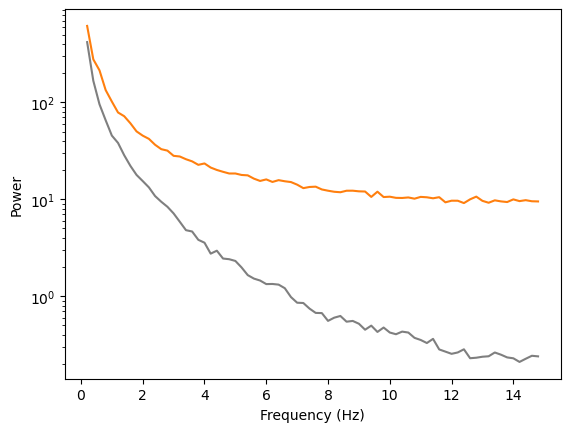

In [162]:
ori_idx = 1
phase_idx = 3
freq_idx = 10
pos_idx = 4

plt.plot(frequencies[1:-1], moving_stim_psd_avg[ori_idx, phase_idx, freq_idx, pos_idx, 1:-1], label='Moving', color='tab:orange')
plt.plot(frequencies[1:-1], stationary_stim_psd_avg[ori_idx, phase_idx, freq_idx, pos_idx, 1:-1], label='Stationary', color='tab:gray')
# plt.plot(frequencies[cutoff_idx:], moving_stim_psd_avg[ori_idx, phase_idx, freq_idx, pos_idx, cutoff_idx:], label='Moving', color='tab:orange')
# plt.plot(frequencies[cutoff_idx:], stationary_stim_psd_avg[ori_idx, phase_idx, freq_idx, pos_idx, cutoff_idx:], label='Stationary', color='tab:gray')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.yscale('log')

plt.savefig(f'../manuscript_figures/fig3_psd_example_ori_{ori_idx}_phase_{phase_idx}_freq_{freq_idx}_pos_{pos_idx}.pdf', format='pdf', bbox_inches='tight')

## Apply filter

In [12]:
# definte the temporal filter in the frequency domain with a linear dropoff at a specific frequency determined by a free parameter theta. Define the filter as a function of a set of temporal frequencies
def temporal_filter(temporal_freqs, theta, low_freq_cutoff=2):
    # create the filter
    filter = np.zeros(temporal_freqs.shape)
    # set the filter to 1 for frequencies below theta
    filter[temporal_freqs <= theta] = 1
    # filter[temporal_freqs < low_freq_cutoff] = 1 - (low_freq_cutoff - temporal_freqs[temporal_freqs < low_freq_cutoff])
    # create a linear dropoff for frequencies above theta with a fixed slope
    filter[temporal_freqs > theta] = 1 - (temporal_freqs[temporal_freqs > theta] - theta)
    # ensure that the filter is non-negative
    filter[filter < 0] = 0
    return np.square(filter)

def temporal_filter_gauss(temporal_freqs, theta_u, theta_s):
    # create the filter as a Gaussian in the frequency domain with mean theta_u and standard deviation theta_s
    filter = np.exp(-0.5 * ((temporal_freqs - theta_u) / theta_s)**2)
    # ensure that the filter is non-negative
    filter[filter < 0] = 0
    return np.square(filter)

def temporal_filter_exp(temporal_freq, theta):
    # create the filter as an exponential in the frequency domain with mean theta_u and standard deviation theta_s
    filter = np.exp(-temporal_freq/theta)
    # ensure that the filter is non-negative
    filter[filter < 0] = 0
    return np.square(filter)

In [61]:
# take the inverse fourier transform of the sqrt of the temporal filter
from scipy.fft import irfftn, ifftshift
# temporal_filter_freq = temporal_filter_gauss(frequencies, 0, 5)
temporal_filter_freq = temporal_filter(frequencies, 6)
temporal_filter_freq[0] = 0
# temporal_filter_freq = temporal_filter(freq, 3)
# temporal_filter_freq = temporal_filter_exp(frequencies, 5)

inverse_temporal_filter = irfftn(np.sqrt(temporal_filter_freq), axes=-1)[:len(frequencies)]


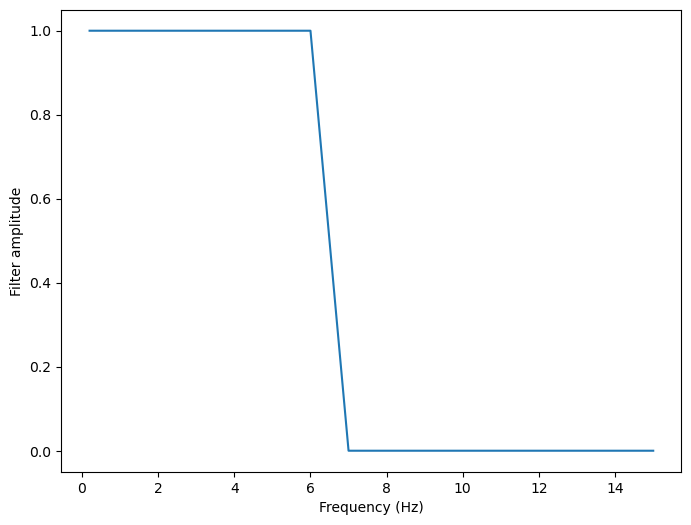

In [63]:
# plot the filter in the frequency domain
plt.figure(figsize=(8, 6))
plt.plot(frequencies[1:], np.sqrt(temporal_filter_freq[1:]), label='Temporal filter', color='tab:blue')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Filter amplitude')
plt.savefig('../manuscript_figures/fig3_temporal_filter_freq.pdf', format='pdf', bbox_inches='tight')

(0.0, 2000.0)

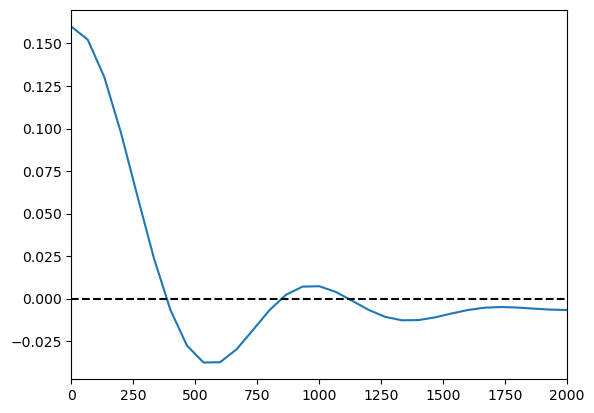

In [57]:
plt.plot(np.linspace(0, 5000, len(frequencies)), inverse_temporal_filter)
plt.axhline(0, color='k', linestyle='--')
plt.xlim(0, 2000)

In [ ]:
# simulate white noise
noise_level = 100
# noise = np.ones(frequencies.shape) * noise_level
noise = np.ones(freq.shape) * noise_level

In [ ]:
# repeat the process again for a range of theta values
num_theta_values = 100
array_shape = moving_stim_psd_avg.shape
theta_values = np.linspace(2, 15, num_theta_values)
moving_stim_information = np.zeros((num_theta_values, array_shape[0], array_shape[1], array_shape[2], array_shape[3]))
stationary_stim_information = np.zeros((num_theta_values, array_shape[0], array_shape[1], array_shape[2], array_shape[3]))
moving_stim_energy = np.zeros((num_theta_values, array_shape[0], array_shape[1], array_shape[2], array_shape[3]))
stationary_stim_energy = np.zeros((num_theta_values, array_shape[0], array_shape[1], array_shape[2], array_shape[3]))
moving_stim_energy_linear = np.zeros((num_theta_values, array_shape[0], array_shape[1], array_shape[2], array_shape[3]))
stationary_stim_energy_linear = np.zeros((num_theta_values, array_shape[0], array_shape[1], array_shape[2], array_shape[3]))
moving_stim_energy_quadratic = np.zeros((num_theta_values, array_shape[0], array_shape[1], array_shape[2], array_shape[3]))
stationary_stim_energy_quadratic = np.zeros((num_theta_values, array_shape[0], array_shape[1], array_shape[2], array_shape[3]))
for i in tqdm(range(num_theta_values)):
    # compute the filter
    filter = temporal_filter(frequencies, theta_values[i])
    # compute the filtered spectra
    filtered_stationary_stim_psd_avg = np.multiply(stationary_stim_psd_avg, filter)
    filtered_moving_stim_psd_avg = np.multiply(moving_stim_psd_avg, filter)
    # compute the information
    moving_stim_information[i] = np.sum(np.log2(1 + filtered_moving_stim_psd_avg / noise), axis=-1)
    stationary_stim_information[i] = np.sum(np.log2(1 + filtered_stationary_stim_psd_avg / noise), axis=-1)
    # compute the energy
    moving_stim_energy[i] = np.sum(filtered_moving_stim_psd_avg, axis=-1)
    stationary_stim_energy[i] = np.sum(filtered_stationary_stim_psd_avg, axis=-1)
    
    # compute the energy weighted by the square of the frequencies
    moving_stim_energy_quadratic[i] = np.sum(filtered_moving_stim_psd_avg*frequencies**2, axis=-1)
    stationary_stim_energy_quadratic[i] = np.sum(filtered_stationary_stim_psd_avg*frequencies**2, axis=-1)
    
    # compute the energy linearly weighted by frequency
    moving_stim_energy_linear[i] = np.sum(filtered_moving_stim_psd_avg*frequencies, axis=-1)
    stationary_stim_energy_linear[i] = np.sum(filtered_stationary_stim_psd_avg*frequencies, axis=-1)


In [ ]:
# plot an example of the psd before and after filtering
fig, ax = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

filter = temporal_filter(frequencies, 6)

ori_idx = 0
phase_idx = 0
wavelength_idx = 8
position_idx = 4

ax[0].plot(frequencies, moving_stim_psd_avg[ori_idx, phase_idx, wavelength_idx, position_idx, :], label='Moving', color='tab:blue')
ax[0].plot(frequencies, stationary_stim_psd_avg[ori_idx, phase_idx, wavelength_idx, position_idx, :], label='Stationary', color='tab:red')
ax[1].plot(frequencies, np.multiply(moving_stim_psd_avg[ori_idx, phase_idx, wavelength_idx, position_idx, :], filter), label='Moving', color='tab:blue')
ax[1].plot(frequencies, np.multiply(stationary_stim_psd_avg[ori_idx, phase_idx, wavelength_idx, position_idx, :], filter), label='Stationary', color='tab:red')
ax[1].set_yscale('log')

In [ ]:
moving_test_informations = moving_stim_information[:, ori_idx, phase_idx, wavelength_idx, position_idx]
stationary_test_informations = stationary_stim_information[:, ori_idx, phase_idx, wavelength_idx, position_idx]
moving_test_energy = moving_stim_energy[:, ori_idx, phase_idx, wavelength_idx, position_idx]
stationary_test_energy = stationary_stim_energy[:, ori_idx, phase_idx, wavelength_idx, position_idx]

# create a subplot with 1 row and 3 columns. First column plot the information vs. theta, second column plot the energy vs. theta, third column plot the information vs. energy
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].plot(theta_values, moving_test_informations, color='tab:blue', label='Moving test')
axs[0].plot(theta_values, stationary_test_informations, color='tab:red', label='Stationary test')
axs[0].set_xlabel('Theta')
axs[0].set_ylabel('Information')
axs[0].set_title('Information vs. theta')
axs[0].legend()
axs[1].plot(theta_values, moving_test_energy, color='tab:blue', label='Moving test')
axs[1].plot(theta_values, stationary_test_energy, color='tab:red', label='Stationary test')
axs[1].set_xlabel('Theta')
axs[1].set_ylabel('Energy')
axs[1].set_title('Energy vs. theta')
axs[1].legend()
axs[2].plot(moving_test_energy, moving_test_informations, color='tab:blue', label='Moving test')
axs[2].plot(stationary_test_energy, stationary_test_informations, color='tab:red', label='Stationary test')
axs[2].set_xlabel('Energy')
axs[2].set_ylabel('Information')
axs[2].set_title('Information vs. energy')
axs[2].legend()
plt.tight_layout()
plt.show()

In [ ]:
lmbd_arr = np.logspace(-5, -3, 16)

fig, ax = plt.subplots(4, 4, figsize=(16, 16))

for i, lmbd in enumerate(lmbd_arr):
    moving_utility = moving_test_informations - lmbd*moving_test_energy
    stationary_utility = stationary_test_informations - lmbd*stationary_test_energy
    ax[i//4, i%4].plot(theta_values, moving_utility, color='tab:blue', label='Moving test')
    ax[i//4, i%4].plot(theta_values, stationary_utility, color='tab:red', label='Stationary test')
    ax[i//4, i%4].set_title('Lambda = ' + str(np.round(lmbd, 7)))

In [ ]:
# for each filter, for a given energy find the closest value of theta which has that energy
energy_arr = np.logspace(6, 11, 1000)

optimal_theta_val_mov = np.zeros((len(energy_arr), len(orientation_arr), len(phase_arr), len(wavelength_arr[low_spatial_freq_idx]), len(position_arr)))
optimal_theta_val_stat = np.zeros((len(energy_arr), len(orientation_arr), len(phase_arr), len(wavelength_arr[low_spatial_freq_idx]), len(position_arr)))
optimal_theta_val_mov_linear = np.zeros((len(energy_arr), len(orientation_arr), len(phase_arr), len(wavelength_arr[low_spatial_freq_idx]), len(position_arr)))
optimal_theta_val_stat_linear = np.zeros((len(energy_arr), len(orientation_arr), len(phase_arr), len(wavelength_arr[low_spatial_freq_idx]), len(position_arr)))
optimal_theta_val_mov_quadratic = np.zeros((len(energy_arr), len(orientation_arr), len(phase_arr), len(wavelength_arr[low_spatial_freq_idx]), len(position_arr)))
optimal_theta_val_stat_quadratic = np.zeros((len(energy_arr), len(orientation_arr), len(phase_arr), len(wavelength_arr[low_spatial_freq_idx]), len(position_arr)))

# loop over orientation, phase, wavelength, position
for ori_idx in range(len(orientation_arr)):
    for phase_idx in range(len(phase_arr)):
        for wavelength_idx in range(len(wavelength_arr[low_spatial_freq_idx])):
            for position_idx in range(len(position_arr)):
                test_moving_energy = moving_stim_energy[:, ori_idx, phase_idx, wavelength_idx, position_idx]
                test_stationary_energy = stationary_stim_energy[:, ori_idx, phase_idx, wavelength_idx, position_idx]
                # interpolate the energy values to get a smooth curve
                test_moving_theta_interp = np.interp(energy_arr, test_moving_energy, theta_values)
                test_stationary_theta_interp = np.interp(energy_arr, test_stationary_energy, theta_values)
                optimal_theta_val_mov[:, ori_idx, phase_idx, wavelength_idx, position_idx] = test_moving_theta_interp
                optimal_theta_val_stat[:, ori_idx, phase_idx, wavelength_idx, position_idx] = test_stationary_theta_interp

                # repeat for the linear energy
                test_moving_energy_linear = moving_stim_energy_linear[:, ori_idx, phase_idx, wavelength_idx, position_idx]
                test_stationary_energy_linear = stationary_stim_energy_linear[:, ori_idx, phase_idx, wavelength_idx, position_idx]
                # interpolate the energy values to get a smooth curve
                test_moving_theta_interp_linear = np.interp(energy_arr, test_moving_energy_linear, theta_values)
                test_stationary_theta_interp_linear = np.interp(energy_arr, test_stationary_energy_linear, theta_values)
                optimal_theta_val_mov_linear[:, ori_idx, phase_idx, wavelength_idx, position_idx] = test_moving_theta_interp_linear
                optimal_theta_val_stat_linear[:, ori_idx, phase_idx, wavelength_idx, position_idx] = test_stationary_theta_interp_linear
                
                # repeat for the quadratic energy
                test_moving_energy_quadratic = moving_stim_energy_quadratic[:, ori_idx, phase_idx, wavelength_idx, position_idx]
                test_stationary_energy_quadratic = stationary_stim_energy_quadratic[:, ori_idx, phase_idx, wavelength_idx, position_idx]
                # interpolate the energy values to get a smooth curve
                test_moving_theta_interp_quadratic = np.interp(energy_arr, test_moving_energy_quadratic, theta_values)
                test_stationary_theta_interp_quadratic = np.interp(energy_arr, test_stationary_energy_quadratic, theta_values)
                optimal_theta_val_mov_quadratic[:, ori_idx, phase_idx, wavelength_idx, position_idx] = test_moving_theta_interp_quadratic
                optimal_theta_val_stat_quadratic[:, ori_idx, phase_idx, wavelength_idx, position_idx] = test_stationary_theta_interp_quadratic

In [ ]:
ori_idx = 0
phase_idx = 0
wavelength_idx = -1
position_idx = 4

# plot the difference in theta values vs. energy

plt.plot(energy_arr, optimal_theta_val_mov[:, ori_idx, phase_idx, wavelength_idx, position_idx]-optimal_theta_val_stat[:, ori_idx, phase_idx, wavelength_idx, position_idx], color='tab:purple')

In [ ]:
optimal_theta_diff = optimal_theta_val_mov - optimal_theta_val_stat
optimal_theta_diff_avg = np.mean(optimal_theta_diff, axis=(1, 2, 4))
optimal_theta_diff_linear = optimal_theta_val_mov_linear - optimal_theta_val_stat_linear
optimal_theta_diff_linear_avg = np.mean(optimal_theta_diff_linear, axis=(1, 2, 4))
optimal_theta_diff_quadratic = optimal_theta_val_mov_quadratic - optimal_theta_val_stat_quadratic
optimal_theta_diff_quadratic_avg = np.mean(optimal_theta_diff_quadratic, axis=(1, 2, 4))

In [ ]:
# plot the average difference in optimal theta, color them with viridis

from matplotlib import cm
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

colors_map = cm.get_cmap('viridis', len(wavelength_arr[low_spatial_freq_idx]))

fig, ax = plt.subplots(1, 3, figsize=(4*3*1.5, 3*1.5), sharey=True)
for i in range(wavelength_arr[low_spatial_freq_idx].shape[0]):
    ax[0].plot(energy_arr, optimal_theta_diff_avg[:, i], color=colors_map(i))
    ax[1].plot(energy_arr, optimal_theta_diff_linear_avg[:, i], color=colors_map(i))
    ax[2].plot(energy_arr, optimal_theta_diff_quadratic_avg[:, i], color=colors_map(i))
ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[2].set_xscale('log')
ax[0].set_title('Unweighted energy')
ax[1].set_title('Linearly weighted energy')
ax[2].set_title('Quadratically weighted energy')
ax[0].set_xlabel('Energy constraint')
ax[1].set_xlabel('Energy constraint')
ax[2].set_xlabel('Energy constraint')
ax[0].set_ylabel('$\\Delta\\theta$ [moving - stationary]')
# add something to indicate that the darker the color, the lower the spatial frequency
# add a colorbar
norm = Normalize(vmin=min(freq_arr[low_spatial_freq_idx]), vmax=max(freq_arr[low_spatial_freq_idx]))
sm = plt.cm.ScalarMappable(cmap=colors_map, norm=norm)
sm.set_array([])


axins1 = inset_axes(
    ax[0],
    width="25%",  # width: 50% of parent_bbox width
    height="5%",  # height: 5%
    loc="upper right",
)
axins1.xaxis.set_ticks_position("bottom")
cbar = fig.colorbar(sm, cax=axins1, orientation="horizontal")
cbar.set_label('spatial freq.\n[cycles/degree]')

axins2 = inset_axes(
    ax[1],
    width="25%",  # width: 50% of parent_bbox width
    height="5%",  # height: 5%
    loc="upper right",
)
axins2.xaxis.set_ticks_position("bottom")
cbar = fig.colorbar(sm, cax=axins2, orientation="horizontal")
cbar.set_label('spatial freq.\n[cycles/degree]')
axins2 = inset_axes(
    ax[2],
    width="25%",  # width: 50% of parent_bbox width
    height="5%",  # height: 5%
    loc="upper right",
)
axins2.xaxis.set_ticks_position("bottom")
cbar = fig.colorbar(sm, cax=axins2, orientation="horizontal")
cbar.set_label('spatial freq.\n[cycles/degree]')

In [ ]:
ori_idx = 0
phase_idx = 0
position_idx = 4

wavelength_idices = [0, 15, -1]

moving_test_energy = moving_stim_energy[:, ori_idx, phase_idx, wavelength_idx, position_idx]
stationary_test_energy = stationary_stim_energy[:, ori_idx, phase_idx, wavelength_idx, position_idx]

# create a subplot with 1 row and 3 columns. First column plot the information vs. theta, second column plot the energy vs. theta, third column plot the information vs. energy
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharex=True)
axs[0].plot(theta_values, moving_stim_energy[:, ori_idx, phase_idx, wavelength_idices[0], position_idx], color='tab:blue', label='Moving test')
axs[0].plot(theta_values, stationary_stim_energy[:, ori_idx, phase_idx, wavelength_idices[0], position_idx], color='tab:red', label='Stationary test')
axs[0].set_xlabel('Theta')
axs[0].set_ylabel('Energy')
axs[0].set_title('Low frequency')
axs[0].legend()
axs[1].plot(theta_values, moving_stim_energy[:, ori_idx, phase_idx, wavelength_idices[1], position_idx], color='tab:blue', label='Moving test')
axs[1].plot(theta_values, stationary_stim_energy[:, ori_idx, phase_idx, wavelength_idices[1], position_idx], color='tab:red', label='Stationary test')
axs[1].set_xlabel('Theta')
axs[1].set_ylabel('Energy')
axs[1].set_title('Mid frequency')
axs[1].legend()
axs[2].plot(theta_values, moving_stim_energy[:, ori_idx, phase_idx, wavelength_idices[2], position_idx], color='tab:blue', label='Moving test')
axs[2].plot(theta_values, stationary_stim_energy[:, ori_idx, phase_idx, wavelength_idices[2], position_idx], color='tab:red', label='Stationary test')
axs[2].set_xlabel('Theta')
axs[2].set_ylabel('Energy')
axs[2].set_title('High frequency')
axs[2].legend()
plt.tight_layout()
plt.show()

In [ ]:
# pick a contraint and then see how a stimulus filtered by the optimal filter looks
constraint_energy = 1e9
constraint_idx = np.argmin(np.abs(energy_arr-constraint_energy))

optimal_theta_mov = optimal_theta_val_mov[constraint_idx, :, :, :, :]
optimal_theta_stat = optimal_theta_val_stat[constraint_idx, :, :, :, :]

ori_idx = 0
phase_idx = 0
wavelength_idx = 3
position_idx = 4

theta_mov = optimal_theta_mov[ori_idx, phase_idx, wavelength_idx, position_idx]
theta_stat = optimal_theta_stat[ori_idx, phase_idx, wavelength_idx, position_idx]

# compute the filter
filter_mov = temporal_filter(frequencies, theta_mov)
filter_stat = temporal_filter(frequencies, theta_stat)
# compute the filtered spectra
filtered_moving_stim_psd = np.multiply(noise, filter_mov)
filtered_stationary_stim_psd = np.multiply(noise, filter_stat)
# compute the energy
test_moving_stim_energy = np.sum(filtered_moving_stim_psd, axis=-1)
test_stationary_stim_energy = np.sum(filtered_stationary_stim_psd, axis=-1)

# compute the energy weighted by the square of the frequencies
test_moving_stim_energy_quadratic = np.sum(filtered_moving_stim_psd*frequencies**2, axis=-1)
test_stationary_stim_energy_quadratic = np.sum(filtered_stationary_stim_psd*frequencies**2, axis=-1)

# compute the energy linearly weighted by frequency
test_moving_stim_energy_linear = np.sum(filtered_moving_stim_psd*frequencies, axis=-1)
test_stationary_stim_energy_linear = np.sum(filtered_stationary_stim_psd*frequencies, axis=-1)


In [ ]:
# create a figure which shows the spectra before filtering, the filter, and the spectra after filtering
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(frequencies, noise, label='Noise', color='tab:gray')
ax[1].plot(frequencies, filter_mov, label='Moving', color='tab:blue')
ax[1].plot(frequencies, filter_stat, label='Stationary', color='tab:red')
ax[2].plot(frequencies, filtered_moving_stim_psd, label='Moving', color='tab:blue')
ax[2].plot(frequencies, filtered_stationary_stim_psd, label='Stationary', color='tab:red')

In [ ]:
# compute the autocorrelation function by taking the inverse fourier transform of the PSD
from scipy.fft import irfft
# compute the autocorrelation function
moving_autocorr = irfft(filtered_moving_stim_psd)[:len(filtered_moving_stim_psd)//2]
stationary_autocorr = irfft(filtered_stationary_stim_psd)[:len(filtered_stationary_stim_psd)//2]

# normalize the autocorrelation function
moving_autocorr /= np.max(moving_autocorr)
stationary_autocorr /= np.max(stationary_autocorr)

time = np.arange(0, len(moving_autocorr)) / 30

# plot the autocorrelation function
fig, ax = plt.subplots(1, 1, figsize=(4*1.5, 3*1.5))
ax.plot(time, moving_autocorr, label='Moving', color='tab:blue')
ax.plot(time, stationary_autocorr, label='Stationary', color='tab:red')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Autocorrelation')
ax.set_title('Autocorrelation function')
ax.legend()
ax.set_xlim(0,2)
plt.show()

## Heatmap energy landscape and theta

### Average over filters

In [46]:
moving_stim_psd.shape

(5, 10, 8, 4, 31, 9, 76)

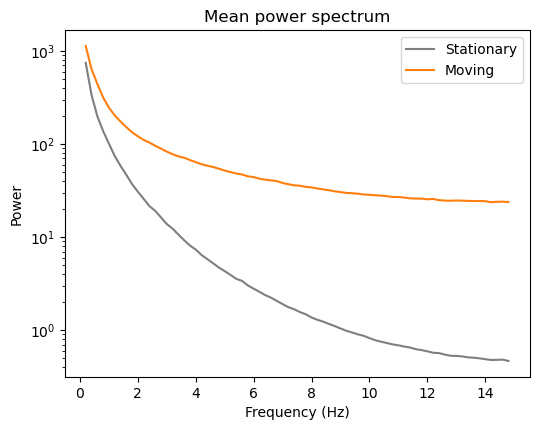

In [47]:
# compute the average spectrum over all filters
mean_moving_psd = np.mean(moving_stim_psd, axis=(0, 1, 2, 3, 4, 5))
mean_stationary_psd = np.mean(stationary_stim_psd, axis=(0, 1, 2, 3, 4, 5))

# plot the mean spectrum
fig, ax = plt.subplots(1, 1, figsize=(4*1.5, 3*1.5))
ax.plot(frequencies[1:-1], mean_stationary_psd[1:-1], label='Stationary', color='tab:gray')
ax.plot(frequencies[1:-1], mean_moving_psd[1:-1], label='Moving', color='tab:orange')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power')
ax.set_title('Mean power spectrum')
ax.set_yscale('log')
ax.legend()

plt.savefig(f'../manuscript_figures/fig3_psd_mean_full.pdf', format='pdf', bbox_inches='tight')

In [48]:
# normalize the spectrum such that the are under the curve is 1
freq_spacing = np.diff(frequencies)[0]
norm_factor = np.sum(mean_stationary_psd*freq_spacing)
mean_stationary_psd /= norm_factor
mean_moving_psd /= norm_factor

In [60]:
np.cumsum(mean_stationary_psd*freq_spacing)

array([8.06620396e-32, 3.72440051e-01, 5.41495121e-01, 6.41061704e-01,
       7.10089473e-01, 7.60576491e-01, 7.97878024e-01, 8.27089323e-01,
       8.50494548e-01, 8.69041293e-01, 8.84421012e-01, 8.97327085e-01,
       9.08087010e-01, 9.17678690e-01, 9.25806691e-01, 9.32715919e-01,
       9.38884217e-01, 9.44213427e-01, 9.48842058e-01, 9.52900343e-01,
       9.56579412e-01, 9.59793232e-01, 9.62695608e-01, 9.65311166e-01,
       9.67667628e-01, 9.69824148e-01, 9.71790835e-01, 9.73571699e-01,
       9.75265553e-01, 9.76778719e-01, 9.78175141e-01, 9.79467608e-01,
       9.80658194e-01, 9.81776020e-01, 9.82808109e-01, 9.83762276e-01,
       9.84646685e-01, 9.85486280e-01, 9.86269248e-01, 9.87011003e-01,
       9.87695534e-01, 9.88342443e-01, 9.88961169e-01, 9.89545155e-01,
       9.90099230e-01, 9.90621227e-01, 9.91114733e-01, 9.91587947e-01,
       9.92039662e-01, 9.92474937e-01, 9.92886226e-01, 9.93276932e-01,
       9.93653384e-01, 9.94017844e-01, 9.94370139e-01, 9.94714189e-01,
      

In [66]:
np.where(np.cumsum(mean_moving_psd*freq_spacing) <= auc_val)

(array([0, 1, 2]),)

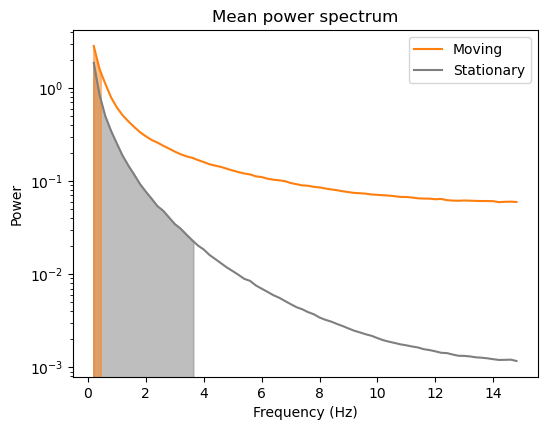

In [97]:
# compute the average spectrum over all filters
# plot the mean spectrum
fig, ax = plt.subplots(1, 1, figsize=(4*1.5, 3*1.5))
ax.plot(frequencies[1:-1], mean_moving_psd[1:-1], label='Moving', color='tab:orange')
ax.plot(frequencies[1:-1], mean_stationary_psd[1:-1], label='Stationary', color='tab:gray')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power')
ax.set_title('Mean power spectrum')
ax.set_yscale('log')
# ax.set_xscale('log')
ax.legend()

# find where the area under the stationary psd is a certain value
# auc_val = 1
# aoc_idx_stat = np.where(np.cumsum(mean_stationary_psd*freq_spacing) <= auc_val)[0][-1]
# # find the frequency at that index
# freq_val_stat = frequencies[aoc_idx_stat]
# auc_idx_mov = np.where(np.cumsum(mean_moving_psd*freq_spacing) <= auc_val)[0][-1]
# # find the frequency at that index
# freq_val_mov = frequencies[auc_idx_mov]

auc_val = .95
cum_stationary = np.cumsum(mean_stationary_psd * freq_spacing)
cum_moving = np.cumsum(mean_moving_psd * freq_spacing)

# Interpolate to find the frequency where the cumulative sum reaches auc_val
freq_val_stat = np.interp(auc_val, cum_stationary, frequencies)
freq_val_mov = np.interp(auc_val, cum_moving, frequencies)

# # plot filled area under the curve
# ax.fill_between(frequencies[1:-1], mean_stationary_psd[1:-1], where=(frequencies[1:-1] <= freq_val_stat), color='tab:gray', alpha=0.5)
# ax.fill_between(frequencies[1:-1], mean_moving_psd[1:-1], where=(frequencies[1:-1] <= freq_val_mov), color='tab:orange', alpha=0.5)

# Interpolate the PSD at the cutoff frequencies
psd_val_stat = np.interp(freq_val_stat, frequencies, mean_stationary_psd)
psd_val_mov = np.interp(freq_val_mov, frequencies, mean_moving_psd)

# For fill_between, extend the frequency and PSD arrays to include the interpolated cutoff point
def extend_for_fill(frequencies, psd, cutoff_freq, cutoff_psd):
    mask = frequencies <= cutoff_freq
    # Find the last index before the cutoff
    last_idx = np.where(mask)[0][-1]
    # Insert the cutoff point after last_idx
    new_freqs = np.insert(frequencies[mask], last_idx + 1, cutoff_freq)
    new_psd = np.insert(psd[mask], last_idx + 1, cutoff_psd)
    return new_freqs, new_psd

freqs_stat_fill, psd_stat_fill = extend_for_fill(frequencies[1:-1], mean_stationary_psd[1:-1], freq_val_stat, psd_val_stat)
freqs_mov_fill, psd_mov_fill = extend_for_fill(frequencies[1:-1], mean_moving_psd[1:-1], freq_val_mov, psd_val_mov)

# plot filled area under the curve using the interpolated cutoff
ax.fill_between(freqs_stat_fill, psd_stat_fill, color='tab:gray', alpha=0.5)
ax.fill_between(freqs_mov_fill, psd_mov_fill, color='tab:orange', alpha=0.5)


plt.savefig(f'../manuscript_figures/fig3_psd_mean_normalize_2Hz_crop_auc_{auc_val}.pdf', format='pdf', bbox_inches='tight')

In [94]:
psd_stat_fill

array([1.86220025e+00, 8.45275349e-01, 4.97832915e-01, 3.45138844e-01,
       2.52435092e-01, 1.86507663e-01, 1.46056497e-01, 1.17026123e-01,
       9.27337262e-02, 7.68985947e-02, 6.45303646e-02, 5.37996240e-02,
       4.79584033e-02, 4.06400026e-02, 3.45461391e-02, 3.08414915e-02,
       2.66460516e-02, 2.31431551e-02, 2.02914247e-02, 1.83953421e-02,
       1.60691010e-02, 1.45118829e-02, 1.30777868e-02, 1.17823140e-02,
       1.07825977e-02, 9.83343533e-03, 8.90432012e-03, 8.46927126e-03,
       7.56582732e-03, 6.98211016e-03, 6.46233678e-03, 5.95292763e-03,
       5.58913043e-03, 5.16044608e-03, 4.77083510e-03, 4.42204588e-03,
       4.19797228e-03, 3.91484104e-03, 3.70877728e-03, 3.42265501e-03,
       3.23454413e-03, 3.09362738e-03, 2.91993275e-03, 2.77037453e-03,
       2.60998242e-03, 2.46753146e-03, 2.36606956e-03, 2.25857497e-03,
       2.17637431e-03, 2.05644645e-03, 1.95352822e-03, 1.88226009e-03,
       1.82230291e-03, 1.76147364e-03, 1.72024980e-03, 1.67061102e-03,
      

In [ ]:
# plot the energy vs. theta
fig, ax = plt.subplots(1, 1, figsize=(4*1.5, 3*1.5))
ax.plot(frequencies[1:], np.cumsum(mean_stationary_psd*freq_spacing)[1:], label='Stationary', color='tab:gray')
ax.plot(frequencies[1:], np.cumsum(mean_moving_psd*freq_spacing)[1:], label='Moving', color='tab:orange')
ax.axhline(y=auc_val, color='k', linestyle='--')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Energy')
ax.set_title('Energy vs. theta')
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend()
plt.savefig(f'../manuscript_figures/fig3_energy_vs_freq_aoc_{auc_val}.pdf', format='pdf', bbox_inches='tight')

In [ ]:
# repeat the process again for a range of theta values
num_theta_values = 1000
theta_values = np.linspace(0, 15, num_theta_values)
moving_stim_energy = np.zeros(num_theta_values)
stationary_stim_energy = np.zeros(num_theta_values)
for i in tqdm(range(num_theta_values)):
    # compute the filter
    filter = temporal_filter(frequencies, theta_values[i])
    # compute the filtered spectra
    filtered_mean_stationary_psd = np.multiply(mean_stationary_psd, filter)
    filtered_mean_moving_psd = np.multiply(mean_moving_psd, filter)
    # compute the energy
    moving_stim_energy[i] = np.sum(filtered_mean_moving_psd*freq_spacing, axis=-1)
    stationary_stim_energy[i] = np.sum(filtered_mean_stationary_psd*freq_spacing, axis=-1)

In [ ]:
# plot the energy vs. theta
fig, ax = plt.subplots(1, 1, figsize=(4*1.5, 3*1.5))
ax.plot(theta_values[:], moving_stim_energy[:], label='Moving', color='tab:orange')
ax.plot(theta_values[:], stationary_stim_energy[:], label='Stationary', color='tab:gray')
ax.set_xlabel('Theta')
ax.set_ylabel('Energy')
ax.set_title('Energy vs. theta')
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend()

In [ ]:
relative = True

# for given energy capacities in the stationary case (between 0 and 1)
energy_capacity_stat = np.linspace(0, 1, 101)
# energy_capacity_mov = np.linspace(0, 2, 101)
delta_energy_capacity = np.linspace(0.01, 10, 1000)
# energy_capacity_stat = np.logspace(-1, 0, 100)
# delta_energy_capacity = np.logspace(-1, 1, 101)

# interpolate the energy values to get a smooth curve
stationary_theta_interp = np.interp(energy_capacity_stat, stationary_stim_energy, theta_values)

if relative:
    energy_capacity_mov = np.outer(delta_energy_capacity, energy_capacity_stat) + energy_capacity_stat[np.newaxis, :] # relative
    delta_energy_capacity *= 100 # convert to percent
else:
    energy_capacity_mov = delta_energy_capacity[:, np.newaxis] + energy_capacity_stat[np.newaxis, :] # absolute

moving_theta_interp = np.interp(energy_capacity_mov, moving_stim_energy, theta_values)


In [ ]:
import matplotlib.colors as mcolors
from matplotlib import cm

norm = mcolors.Normalize(vmin=np.min(theta_values), vmax=np.max(theta_values))
two_color_norm = mcolors.TwoSlopeNorm(vmin=-5, vcenter=0, vmax=5)

# example_points = [(50, 50), (75, 75), (95, 100)]
example_points = [(75, 9), (90, 19), (95, 29), (99, 49)]

fig, ax = plt.subplots(1, 3, figsize=(16, 5), width_ratios=[5, 5, 5], sharey=True)
im0 = ax[0].imshow(np.repeat(stationary_theta_interp[np.newaxis, :], len(delta_energy_capacity), axis=0), origin='lower', norm=norm, cmap='gray_r', extent=[energy_capacity_stat[0], energy_capacity_stat[-1], delta_energy_capacity[0], delta_energy_capacity[-1]], aspect='auto')
ax[0].set_title('Stationary theta')
im1 = ax[1].imshow(moving_theta_interp, origin='lower', norm=norm, cmap='gray_r', extent=[energy_capacity_stat[0], energy_capacity_stat[-1], delta_energy_capacity[0], delta_energy_capacity[-1]], aspect='auto')
ax[1].set_title('Moving theta')
colors_map = mcolors.LinearSegmentedColormap.from_list('custom_cmap', [(1, 127/255, 14/255), (1, 1, 1), (0.5, 0.5, 0.5)], N=256)
im2 = ax[2].imshow(stationary_theta_interp[np.newaxis, :]-moving_theta_interp, origin='lower', norm=two_color_norm, cmap=colors_map, extent=[energy_capacity_stat[0], energy_capacity_stat[-1], delta_energy_capacity[0], delta_energy_capacity[-1]], aspect='auto')
ax[2].set_title('Difference in theta [stationary - moving]')
# ax[2].set_xlim(0.5, 1)
# ax[2].set_ylim(0.5, 1)
# add axis labels
if relative:
    ax[0].set_ylabel('Percentage increase in energy capacity')
else:
    ax[0].set_ylabel('Increase in energy capacity')

fig.supxlabel('Energy capacity')

# plot the example points in three different colors which are distinct from red, white and blue
colors_map = cm.get_cmap('Blues', len(example_points)+2)
# plot the example points in the first subplot
for i, point in enumerate(example_points):
    ax[0].scatter(energy_capacity_stat[point[0]], delta_energy_capacity[point[1]], color=colors_map(i+1), s=100, edgecolor='black', label='Example point ' + str(i+1))
    ax[1].scatter(energy_capacity_stat[point[0]], delta_energy_capacity[point[1]], color=colors_map(i+1), s=100, edgecolor='black')
    ax[2].scatter(energy_capacity_stat[point[0]], delta_energy_capacity[point[1]], color=colors_map(i+1), s=100, edgecolor='black')

ax[0].set_yscale('log')

# add a colorbar without disrupting the layout of the other subplots
cbar = fig.colorbar(im2, ax=ax[2], orientation='vertical', pad=0.04)
cbar = fig.colorbar(im1, ax=ax[1], orientation='vertical', pad=0.04)
cbar = fig.colorbar(im0, ax=ax[0], orientation='vertical', pad=0.04)
plt.savefig(f'../manuscript_figures/fig3_diff_theta_stat_energy_vs_delta_energy.pdf', format='pdf', bbox_inches='tight')

In [ ]:
stationary_theta_interp[example_points[-1][0]]

In [ ]:
example_filter_mov.shape

In [ ]:
from scipy.fft import irfft

# compute the autocorrelation function for the example points by extracting the theta values in the stationary and moving conditions and then applying the filter to white noise and then computing the autocorrelation function as the inverse fourier transform of the PSD
alpha_arr = [0.25, 0.5, 0.75, 1]
fig, ax = plt.subplots(1, 1, figsize=(4*1.5, 3*1.5))
for i in range(len(example_points)):
    # compute the filter
    example_theta_mov = moving_theta_interp[example_points[i][1], example_points[i][0]]
    example_theta_stat = stationary_theta_interp[example_points[i][0]]
    # compute the filter
    example_filter_mov = temporal_filter(frequencies, example_theta_mov)
    example_filter_stat = temporal_filter(frequencies, example_theta_stat)
    # compute the inverse fourier transform
    example_moving_autocorr = irfft(example_filter_mov/freq_spacing)
    example_stationary_autocorr = irfft(example_filter_stat/freq_spacing)
    # normalize the autocorrelation function
    example_moving_autocorr /= np.max(example_moving_autocorr)
    example_stationary_autocorr /= np.max(example_stationary_autocorr)
    # plot the autocorrelation function
    time = np.arange(0, len(example_moving_autocorr)) / 30*1000
    ax.plot(time, example_moving_autocorr, label='Moving', color='tab:orange', alpha=alpha_arr[i])
    ax.plot(time, example_stationary_autocorr, label='Stationary', color='tab:gray', alpha=alpha_arr[i])
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Autocorrelation')
    # ax.legend()
    ax.set_xlim(0, 500)
plt.savefig(f'../manuscript_figures/fig3_autocorr_example_{i}.pdf', format='pdf', bbox_inches='tight')
plt.show()
plt.close(fig)

### Individual filters

In [ ]:
stationary_stim_psd_avg.shape

In [ ]:
# normalize the spectrum such that the are under the curve is 1
norm_factor = np.sum(stationary_stim_psd_avg[:, :, :, :, :]*freq_spacing, axis=-1, keepdims=True)
stationary_stim_psd_avg_norm = stationary_stim_psd_avg[:, :, :, :, :] / norm_factor
moving_stim_psd_avg_norm = moving_stim_psd_avg[:, :, :, :, :] / norm_factor

mat_shape = stationary_stim_psd_avg_norm.shape

# repeat the process again for a range of theta values
num_theta_values = 1000
theta_values = np.linspace(0, 15, num_theta_values)
moving_stim_energy = np.zeros((mat_shape[0], mat_shape[1], mat_shape[2], mat_shape[3], num_theta_values))
stationary_stim_energy = np.zeros((mat_shape[0], mat_shape[1], mat_shape[2], mat_shape[3], num_theta_values))
for i in tqdm(range(num_theta_values)):
    # compute the filter
    filter = temporal_filter(frequencies, theta_values[i])
    # compute the filtered spectra
    filtered_mean_stationary_psd = np.multiply(stationary_stim_psd_avg_norm, filter)
    filtered_mean_moving_psd = np.multiply(moving_stim_psd_avg_norm, filter)
    # compute the energy
    moving_stim_energy[:, :, :, :, i] = np.sum(filtered_mean_moving_psd*freq_spacing, axis=-1)
    stationary_stim_energy[:, :, :, :, i] = np.sum(filtered_mean_stationary_psd*freq_spacing, axis=-1)

In [ ]:
# for given energy capacities in the stationary case (between 0 and 1)
relative = True

num_energy_levels = 100
energy_capacity_stat = np.linspace(0, 1, num_energy_levels+1)
delta_energy_capacity = np.linspace(0.01, 10, 10*num_energy_levels)
if relative:
    energy_capacity_mov = np.outer(delta_energy_capacity, energy_capacity_stat) + energy_capacity_stat[np.newaxis, :] # relative
    delta_energy_capacity *= 100 # convert to percent
else:
    energy_capacity_mov = delta_energy_capacity[:, np.newaxis] + energy_capacity_stat[np.newaxis, :]
# energy_capacity_stat = np.logspace(-1, 0, 100)
# delta_energy_capacity = np.logspace(-1, 0, 100)

stationary_theta_interp = np.zeros((num_energy_levels+1, mat_shape[0], mat_shape[1], mat_shape[2], mat_shape[3]))
moving_theta_interp = np.zeros((10*num_energy_levels, num_energy_levels+1, mat_shape[0], mat_shape[1], mat_shape[2], mat_shape[3]))

# interpolate the energy values to get a smooth curve
for i in range(mat_shape[0]):
    for j in range(mat_shape[1]):
        for k in range(mat_shape[2]):
            for l in range(mat_shape[3]):
                # interpolate the energy values to get a smooth curve
                stationary_theta_interp[:, i, j, k, l] = np.interp(energy_capacity_stat, stationary_stim_energy[i, j, k, l], theta_values)
                for m in range(num_energy_levels):
                    # interpolate the energy values to get a smooth curve
                    moving_theta_interp[:, m, i, j, k, l] = np.interp(energy_capacity_mov[:, m], moving_stim_energy[i, j, k, l], theta_values)

In [ ]:
# for each filter, find the cutoff value of the autocorrelation function for different points in the energy landscape
# create a matrix to store the cutoff values for each filter
cutoff_frequency_mov = np.zeros((len(example_points), mat_shape[0], mat_shape[1], mat_shape[2], mat_shape[3]))
cutoff_frequency_stat = np.zeros((len(example_points), mat_shape[0], mat_shape[1], mat_shape[2], mat_shape[3]))
autocorr_func_mov = np.zeros((len(example_points), mat_shape[0], mat_shape[1], mat_shape[2], mat_shape[3], 2*(len(frequencies)-1)))
autocorr_func_stat = np.zeros((len(example_points), mat_shape[0], mat_shape[1], mat_shape[2], mat_shape[3], 2*(len(frequencies)-1)))
cutoff = 0.5
for m in range(len(example_points)):
    for i in range(mat_shape[0]):
        for j in range(mat_shape[1]):
            for k in range(mat_shape[2]):
                for l in range(mat_shape[3]):
                    # compute the filter
                    example_theta_mov = moving_theta_interp[example_points[m][1], example_points[m][0], i, j, k, l]
                    example_theta_stat = stationary_theta_interp[example_points[m][0], i, j, k, l]
                    # compute the filter
                    example_filter_mov = temporal_filter(frequencies, example_theta_mov)
                    example_filter_stat = temporal_filter(frequencies, example_theta_stat)
                    # compute the filtered spectra
                    example_filtered_mean_stationary_psd = example_filter_stat # np.multiply(stationary_stim_psd_avg_norm[i, j, k, l], example_filter_stat)
                    example_filtered_mean_moving_psd = example_filter_mov # np.multiply(moving_stim_psd_avg_norm[i, j, k, l], example_filter_mov)
                    # compute the inverse fourier transform
                    example_moving_autocorr = irfft(example_filtered_mean_moving_psd)
                    example_stationary_autocorr = irfft(example_filtered_mean_stationary_psd)
                    # normalize the autocorrelation function
                    example_moving_autocorr /= np.max(example_moving_autocorr)
                    example_stationary_autocorr /= np.max(example_stationary_autocorr)
                    # store the autocorrelation function
                    autocorr_func_mov[m, i, j, k, l, :] = example_moving_autocorr
                    autocorr_func_stat[m, i, j, k, l, :] = example_stationary_autocorr
                    # find the cutoff frequency
                    try:
                        cutoff_frequency_mov[m, i, j, k, l] = np.where(example_moving_autocorr < cutoff)[0][0]
                    except IndexError:
                        cutoff_frequency_mov[m, i, j, k, l] = len(example_moving_autocorr)
                    try:
                        cutoff_frequency_stat[m, i, j, k, l] = np.where(example_stationary_autocorr < cutoff)[0][0]
                    except IndexError:
                        cutoff_frequency_stat[m, i, j, k, l] = len(example_stationary_autocorr)


In [ ]:
# plot and save all autocorrelation functions
# make a directory called example_autocorrelation_sim in ../manuscript_figures/
import os
if not os.path.exists('../manuscript_figures/example_autocorrelation_sim_-1_1_white_noise_band_pass'):
    os.makedirs('../manuscript_figures/example_autocorrelation_sim_-1_1_white_noise_band_pass')


point_idx = 0
position_idx = 4
time = np.arange(0, len(example_moving_autocorr)) / 30*1000
for ori_idx in range(mat_shape[0]):
    for phase_idx in range(mat_shape[1]):
        for wavelength_idx in range(mat_shape[2]):
            fig, ax = plt.subplots(1, 1, figsize=(4, 3))
            ax.plot(time, autocorr_func_mov[point_idx, ori_idx, phase_idx, wavelength_idx, position_idx, :], label='Moving', color='tab:orange')
            ax.plot(time, autocorr_func_stat[point_idx, ori_idx, phase_idx, wavelength_idx, position_idx, :], label='Stationary', color='tab:gray')
            ax.set_xlim(0, 500)
            ax.set_xlabel('Time (ms)')
            ax.set_ylabel('Autocorrelation')
            ax.set_title(f'Point {point_idx}, Ori {ori_idx}, Phase {phase_idx}, Wavelength {wavelength_idx}, Position {position_idx}')
            ax.legend()
            ax.set_ylim(-1, 1)
            plt.savefig(f'../manuscript_figures/example_autocorrelation_sim_-1_1_white_noise_band_pass/fig3_autocorr_point_{point_idx}_ori_{ori_idx}_phase_{phase_idx}_wavelength_{wavelength_idx}_position_{position_idx}.pdf', format='pdf', bbox_inches='tight')
            # close the figure
            plt.close(fig)

In [ ]:
# plot the average autocorrelation function for each point
avg_autocorr_func_mov = np.mean(autocorr_func_mov, axis=(1, 2, 3, 4))
avg_autocorr_func_stat = np.mean(autocorr_func_stat, axis=(1, 2, 3, 4))
std_autocorr_func_mov = np.std(autocorr_func_mov, axis=(1, 2, 3, 4))
std_autocorr_func_stat = np.std(autocorr_func_stat, axis=(1, 2, 3, 4))
time = np.arange(0, len(example_moving_autocorr)) / 30*1000
# plot the average autocorrelation function for each point
for point_idx in range(len(example_points)):
    fig, ax = plt.subplots(1, 1, figsize=(4*1.5, 3*1.5))
    ax.plot(time, avg_autocorr_func_mov[point_idx, :], label='Moving', color='tab:orange')
    ax.plot(time, avg_autocorr_func_stat[point_idx, :], label='Stationary', color='tab:gray')
    ax.fill_between(time, avg_autocorr_func_mov[point_idx, :] - std_autocorr_func_mov[point_idx, :], avg_autocorr_func_mov[point_idx, :] + std_autocorr_func_mov[point_idx, :], color='tab:orange', alpha=0.2)
    ax.fill_between(time, avg_autocorr_func_stat[point_idx, :] - std_autocorr_func_stat[point_idx, :], avg_autocorr_func_stat[point_idx, :] + std_autocorr_func_stat[point_idx, :], color='tab:gray', alpha=0.2)
    ax.set_xlim(0, 500)
    ax.set_ylim(-1, 1)
    plt.savefig(f'../manuscript_figures/fig3_avg_autocorr_point_{point_idx}.pdf', format='pdf', bbox_inches='tight')
    plt.show()
    plt.close(fig)

In [ ]:
cutoff_frequency_stat /= 30
cutoff_frequency_mov /= 30

In [ ]:
cutoff_frequency_stat *= 1000
cutoff_frequency_mov *= 1000

In [ ]:
np.unique(diff_cutoff)

In [ ]:
np.linspace(-300, 300, 20)

In [ ]:
# take the difference in cutoffs and plot the histogram
diff_cutoff = cutoff_frequency_mov - cutoff_frequency_stat

bins = np.linspace(-300, 300, 20)

idx = 3

plt.hist(diff_cutoff[idx].flatten(), bins=bins, density=True)
plt.xlabel('Difference of cutoff (moving - stationary) in ms')
plt.axvline(np.mean(diff_cutoff[idx]), color='k', linestyle='--')
plt.savefig('../manuscript_figures/fig3_hist_cutoff_diff_theory.pdf', format='pdf', bbox_inches='tight')

In [ ]:
# plot the cutoff frequencies as a density scatter plot with jitter
point = 3
jitter_strength = 10

# Ensure the x and y axes span the same range
min_val = 0
max_val = max(np.max(cutoff_frequency_stat[point]), np.max(cutoff_frequency_mov[point]))

fig, ax = plt.subplots(1, 1, figsize=(4*1.5, 3*1.5))
ax.set_title('Cutoff frequency')
ax.set_xlabel('Stationary cutoff frequency')
ax.set_ylabel('Moving cutoff frequency')
# add jitter to the points
cutoff_stat_jitter = cutoff_frequency_stat[point, :, :, :, :].flatten() + np.random.normal(0, jitter_strength, cutoff_frequency_stat[point, :, :, :, :].flatten().shape)
cutoff_mov_jitter = cutoff_frequency_mov[point, :, :, :, :].flatten() + np.random.normal(0, jitter_strength, cutoff_frequency_mov[point, :, :, :, :].flatten().shape)

# use gaussian kde to plot the density of points
from scipy.stats import gaussian_kde

kde = gaussian_kde([cutoff_stat_jitter, cutoff_mov_jitter])

# plot scatter plot colored by density
density = kde([cutoff_stat_jitter, cutoff_mov_jitter])
ax.scatter(cutoff_stat_jitter, cutoff_mov_jitter, c=density, cmap='viridis', s=1)
# add a colorbar
cbar = fig.colorbar(ax.collections[0], ax=ax, orientation='vertical')
cbar.set_label('Density')
# add a line with slope 1 which goes from 0 to the max value axes
ax.plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--')
ax.set_xlim(0, 500)
ax.set_ylim(0, 500)
plt.savefig(f'../manuscript_figures/fig3_cutoff_frequency_point_{point}.pdf', format='pdf', bbox_inches='tight')


In [ ]:
# plot the cutoff frequencies as a density scatter plot with jitter
point = 3

# Ensure the x and y axes span the same range
min_val = 0
max_val = max(np.max(cutoff_frequency_stat[point]), np.max(cutoff_frequency_mov[point]))
frame_length = 1/30*1000
bins = np.arange(min_val, max_val+frame_length, frame_length)

fig, ax = plt.subplots(1, 1, figsize=(4*1.5, 3*1.5))
ax.set_title('Cutoff frequency')
ax.set_xlabel('Stationary cutoff lag (ms)')
ax.set_ylabel('Moving cutoff lag (ms)')

ax.hist2d(cutoff_frequency_stat[point, :, :, :, :].flatten(), cutoff_frequency_mov[point, :, :, :, :].flatten(), bins=[bins, bins], cmap='Blues')
# add a colorbar
cbar = fig.colorbar(ax.collections[0], ax=ax, orientation='vertical')
cbar.set_label('Density')
# add a line with slope 1 which goes from 0 to the max value axes
ax.plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--')

plt.savefig(f'../manuscript_figures/fig3_cutoff_frequency_density_hist_point_{point}.pdf', format='pdf', bbox_inches='tight')


In [ ]:
# print the fraction above the diagonal
above_diagonal = np.sum(cutoff_frequency_mov[point] > cutoff_frequency_stat[point]) / (cutoff_frequency_mov[point].flatten().shape[0])
print(f'Fraction of points above the diagonal: {above_diagonal:.2f}')

In [ ]:
import matplotlib.colors as mcolors

norm = mcolors.LogNorm(vmin=np.min(theta_values), vmax=np.max(theta_values))
two_color_norm = mcolors.TwoSlopeNorm(vmin=-5, vcenter=0, vmax=5)

random_draws = 10

for i in range(random_draws):
    ori_idx = np.random.randint(0, mat_shape[0])
    phase_idx = np.random.randint(0, mat_shape[1])
    wavelength_idx = np.random.randint(0, mat_shape[2])
    position_idx = np.random.randint(0, mat_shape[3])

    stationary_theta_test = stationary_theta_interp[:, ori_idx, phase_idx, wavelength_idx, position_idx]
    moving_theta_test = moving_theta_interp[:, :, ori_idx, phase_idx, wavelength_idx, position_idx]

    fig, ax = plt.subplots(2, 3, figsize=(16, 10))
    im0 = ax[0, 0].imshow(np.repeat(stationary_theta_test[np.newaxis, :], 100, axis=0), origin='lower', norm=norm, cmap='viridis', extent=[energy_capacity_stat[0], energy_capacity_stat[-1], delta_energy_capacity[0], delta_energy_capacity[-1]], aspect='auto')
    ax[0, 0].set_title('Stationary theta')
    im1 = ax[0, 1].imshow(moving_theta_test, origin='lower', norm=norm, cmap='viridis', extent=[energy_capacity_stat[0], energy_capacity_stat[-1], delta_energy_capacity[0], delta_energy_capacity[-1]], aspect='auto')
    ax[0, 1].set_title('Moving theta')
    im2 = ax[0, 2].imshow(stationary_theta_test[np.newaxis, :]-moving_theta_test, origin='lower', norm=two_color_norm, cmap='bwr', extent=[energy_capacity_stat[0], energy_capacity_stat[-1], delta_energy_capacity[0], delta_energy_capacity[-1]], aspect='auto')
    ax[0, 2].set_title('Difference in theta [stationary - moving]')
    # add axis labels
    ax[0, 0].set_ylabel('Percentage increase in energy capacity')
    ax[0, 1].set_xlabel('Energy capacity')
    fig.suptitle(f'Orientation: {orientation_arr[ori_idx]}, Phase: {phase_arr[phase_idx]}, Frequency: {freq_arr[low_spatial_freq_idx][wavelength_idx]}, Position: {position_arr[position_idx]}')

    # add a colorbar without disrupting the layout of the other subplots
    cbar = fig.colorbar(im2, ax=ax[0, 2], orientation='vertical', fraction=0.02, pad=0.04)
    cbar = fig.colorbar(im1, ax=ax[0, 1], orientation='vertical', fraction=0.02, pad=0.04)
    cbar = fig.colorbar(im0, ax=ax[0, 0], orientation='vertical', fraction=0.02, pad=0.04)

    # plot the spectra and the energy vs. theta
    ax[1, 0].plot(frequencies, stationary_stim_psd_avg[ori_idx, phase_idx, wavelength_idx, position_idx, :], label='Stationary', color='tab:red')
    ax[1, 0].plot(frequencies, moving_stim_psd_avg[ori_idx, phase_idx, wavelength_idx, position_idx, :], label='Moving', color='tab:blue')
    ax[1, 0].set_xlabel('Frequency (Hz)')
    ax[1, 0].set_ylabel('Power')
    ax[1, 0].set_title('Power spectrum')
    ax[1, 0].set_yscale('log')
    ax[1, 1].plot(theta_values, stationary_stim_energy[ori_idx, phase_idx, wavelength_idx, position_idx, :], label='Stationary', color='tab:red')
    ax[1, 1].plot(theta_values, moving_stim_energy[ori_idx, phase_idx, wavelength_idx, position_idx, :], label='Moving', color='tab:blue')
    ax[1, 1].set_xlabel('Theta')
    ax[1, 1].set_ylabel('Energy')
    ax[1, 1].set_title('Energy vs. theta')
    # make last plot empty
    ax[1, 2].axis('off')

    plt.show()

### Block trial stimuli

In [ ]:
import numpy as np
# create white noise block structure, have 1 second of white noise with low variance and then 1 second of white noise with high variance
# the sampling rate is 10 ms.
num_samples = 100  # number of samples in the white noise block
low_noise = 0.1
high_noise = 1
sampling_rate = 100

# repeat this 100 times with new sampling so that in the end I have an array of shape (100, 300)
num_blocks = 100
white_noise_blocks = np.array([np.concatenate([
    np.random.normal(0, low_noise, 20),  # low variance
    np.random.normal(0, high_noise, num_samples),     # high variance
    np.random.normal(0, low_noise, 80),  # low variance
]) for _ in range(num_blocks)])

# take the fft of the white noise blocks
white_noise_blocks_fft = np.fft.rfft(white_noise_blocks, axis=-1)
white_noise_frequencies = np.fft.rfftfreq(white_noise_blocks.shape[1], d=1/sampling_rate)

In [ ]:
avg_white_noise_psd = np.mean(np.abs(white_noise_blocks_fft)**2, axis=0)[4:]

In [ ]:
import matplotlib.pyplot as plt
plt.plot(white_noise_frequencies[4:], avg_white_noise_psd)

In [ ]:
# for each filter, find the cutoff value of the autocorrelation function for different points in the energy landscape
# create a matrix to store the cutoff values for each filter
cutoff_frequency_mov = np.zeros((len(example_points), mat_shape[0], mat_shape[1], mat_shape[2], mat_shape[3]))
cutoff_frequency_stat = np.zeros((len(example_points), mat_shape[0], mat_shape[1], mat_shape[2], mat_shape[3]))
autocorr_func_mov = np.zeros((len(example_points), mat_shape[0], mat_shape[1], mat_shape[2], mat_shape[3], len(white_noise_frequencies[4:])//2))
autocorr_func_stat = np.zeros((len(example_points), mat_shape[0], mat_shape[1], mat_shape[2], mat_shape[3], len(white_noise_frequencies[4:])//2))
cutoff = 0.5
for m in range(len(example_points)):
    for i in range(mat_shape[0]):
        for j in range(mat_shape[1]):
            for k in range(mat_shape[2]):
                for l in range(mat_shape[3]):
                    # compute the filter
                    example_theta_mov = moving_theta_interp[example_points[m][1], example_points[m][0], i, j, k, l]
                    example_theta_stat = stationary_theta_interp[example_points[m][0], i, j, k, l]
                    # compute the filter
                    example_filter_mov = temporal_filter(white_noise_frequencies[4:], example_theta_mov)
                    example_filter_stat = temporal_filter(white_noise_frequencies[4:], example_theta_stat)
                    # compute the filtered spectra
                    example_filtered_mean_stationary_psd = np.multiply(avg_white_noise_psd, example_filter_stat)
                    example_filtered_mean_moving_psd = np.multiply(avg_white_noise_psd, example_filter_mov)
                    # compute the inverse fourier transform
                    example_moving_autocorr = irfft(example_filtered_mean_moving_psd)[:len(example_filtered_mean_moving_psd)//2]
                    example_stationary_autocorr = irfft(example_filtered_mean_stationary_psd)[:len(example_filtered_mean_stationary_psd)//2]
                    # normalize the autocorrelation function
                    example_moving_autocorr /= np.max(example_moving_autocorr)
                    example_stationary_autocorr /= np.max(example_stationary_autocorr)
                    # store the autocorrelation function
                    autocorr_func_mov[m, i, j, k, l, :] = example_moving_autocorr
                    autocorr_func_stat[m, i, j, k, l, :] = example_stationary_autocorr
                    # # find the cutoff frequency
                    try:
                        cutoff_frequency_mov[m, i, j, k, l] = np.where(example_moving_autocorr < cutoff)[0][0]
                        cutoff_frequency_stat[m, i, j, k, l] = np.where(example_stationary_autocorr < cutoff)[0][0]
                    except IndexError:
                        # if the cutoff is not found, set it to nan
                        cutoff_frequency_mov[m, i, j, k, l] = np.nan
                        cutoff_frequency_stat[m, i, j, k, l] = np.nan


In [ ]:
# save the autocorrelation and cutoff frequency matrices
np.savez('../data/fig3_autocorr_cutoff_frequency_white_noise.npz', 
         autocorr_func_mov=autocorr_func_mov, 
         autocorr_func_stat=autocorr_func_stat, 
         cutoff_frequency_mov=cutoff_frequency_mov, 
         cutoff_frequency_stat=cutoff_frequency_stat,
         white_noise_frequencies=white_noise_frequencies[4:],
         example_points=example_points,
         frequencies=frequencies[99:],
         theta_values=theta_values,
         stationary_theta_interp=stationary_theta_interp,
         moving_theta_interp=moving_theta_interp)

In [ ]:
time

In [ ]:
autocorr_func_mov.shape

In [ ]:
point_idx = 1
position_idx = 5
ori = 0
phase = 0
wavelength = 3
time = np.arange(0, len(white_noise_frequencies[4:])//2*10, 10)
plt.plot(time, autocorr_func_mov[point_idx, ori_idx, phase_idx, wavelength_idx, position_idx, :], label='Moving', color='tab:orange')
plt.plot(time, autocorr_func_stat[point_idx, ori_idx, phase_idx, wavelength_idx, position_idx, :], label='Moving', color='tab:gray')
plt.xlim(0, 500)
plt.axhline(0, color='black', linestyle='--')

In [ ]:
# plot and save all autocorrelation functions
# make a directory called example_autocorrelation_sim in ../manuscript_figures/
import os
if not os.path.exists('../manuscript_figures/example_autocorrelation_sim_-1_1_block_stim'):
    os.makedirs('../manuscript_figures/example_autocorrelation_sim_-1_1_block_stim')


point_idx = 1
position_idx = 4
for ori_idx in range(mat_shape[0]):
    for phase_idx in range(mat_shape[1]):
        for wavelength_idx in range(mat_shape[2]):
            fig, ax = plt.subplots(1, 1, figsize=(4, 3))
            ax.plot(time, autocorr_func_mov[point_idx, ori_idx, phase_idx, wavelength_idx, position_idx, :], label='Moving', color='tab:orange')
            ax.plot(time, autocorr_func_stat[point_idx, ori_idx, phase_idx, wavelength_idx, position_idx, :], label='Stationary', color='tab:gray')
            ax.set_xlabel('Time (ms)')
            ax.set_ylabel('Autocorrelation')
            ax.set_title(f'Point {point_idx}, Ori {ori_idx}, Phase {phase_idx}, Wavelength {wavelength_idx}, Position {position_idx}')
            ax.legend()
            ax.set_ylim(-1, 1)
            ax.set_xlim(0, 500)
            plt.savefig(f'../manuscript_figures/example_autocorrelation_sim_-1_1_block_stim/fig3_autocorr_point_{point_idx}_ori_{ori_idx}_phase_{phase_idx}_wavelength_{wavelength_idx}_position_{position_idx}_block_stim.pdf', format='pdf', bbox_inches='tight')
            # close the figure
            plt.close(fig)

In [ ]:
# plot the average autocorrelation function for each point
avg_autocorr_func_mov = np.mean(autocorr_func_mov, axis=(1, 2, 3, 4))
avg_autocorr_func_stat = np.mean(autocorr_func_stat, axis=(1, 2, 3, 4))
std_autocorr_func_mov = np.std(autocorr_func_mov, axis=(1, 2, 3, 4))
std_autocorr_func_stat = np.std(autocorr_func_stat, axis=(1, 2, 3, 4))
time = np.arange(0, len(avg_autocorr_func_mov[1])*10, 10)
# plot the average autocorrelation function for each point
for point_idx in range(len(example_points)):
    fig, ax = plt.subplots(1, 1, figsize=(4*1.5, 3*1.5))
    ax.plot(time, avg_autocorr_func_mov[point_idx, :], label='Moving', color='tab:orange')
    ax.plot(time, avg_autocorr_func_stat[point_idx, :], label='Stationary', color='tab:gray')
    ax.fill_between(time, avg_autocorr_func_mov[point_idx, :] - std_autocorr_func_mov[point_idx, :], avg_autocorr_func_mov[point_idx, :] + std_autocorr_func_mov[point_idx, :], color='tab:orange', alpha=0.2)
    ax.fill_between(time, avg_autocorr_func_stat[point_idx, :] - std_autocorr_func_stat[point_idx, :], avg_autocorr_func_stat[point_idx, :] + std_autocorr_func_stat[point_idx, :], color='tab:gray', alpha=0.2)
    # ax.set_xlim(0, 1000)
    ax.set_ylim(-1, 1)
    plt.show()
    plt.savefig(f'../manuscript_figures/fig3_avg_autocorr_point_{point_idx}_block_stimuli.pdf', format='pdf', bbox_inches='tight')
    plt.close(fig)

In [ ]:
# plot the cutoff frequencies as a density scatter plot with jitter
point = 2

jitter_strength = 10

fig, ax = plt.subplots(1, 1, figsize=(4*1.5, 3*1.5))
ax.set_title('Cutoff frequency')
ax.set_xlabel('Stationary cutoff frequency')
ax.set_ylabel('Moving cutoff frequency')
# add jitter to the points and remove nan values
cutoff_frequency_stat_temp = cutoff_frequency_stat[point, :, :, :, :].flatten()
cutoff_frequency_mov_temp = cutoff_frequency_mov[point, :, :, :, :].flatten()
# check what percent of values in cutoff_frequency_mov are nan
print(f'Percent of NaN values in cutoffs: {np.sum(np.isnan(cutoff_frequency_mov_temp))/ cutoff_frequency_mov_temp.size * 100:.2f}%')

cutoff_frequency_stat_temp = cutoff_frequency_stat_temp[~np.isnan(cutoff_frequency_stat_temp)]*10
cutoff_frequency_mov_temp = cutoff_frequency_mov_temp[~np.isnan(cutoff_frequency_mov_temp)]*10

# Ensure the x and y axes span the same range
min_val = 0
max_val = max(np.max(cutoff_frequency_stat_temp), np.max(cutoff_frequency_mov_temp))

cutoff_stat_jitter = cutoff_frequency_stat_temp + np.random.normal(0, jitter_strength, cutoff_frequency_stat_temp.shape)
cutoff_mov_jitter = cutoff_frequency_mov_temp + np.random.normal(0, jitter_strength, cutoff_frequency_mov_temp.shape)

# use gaussian kde to plot the density of points
from scipy.stats import gaussian_kde

kde = gaussian_kde([cutoff_stat_jitter, cutoff_mov_jitter])

# plot scatter plot colored by density
density = kde([cutoff_stat_jitter, cutoff_mov_jitter])
ax.scatter(cutoff_stat_jitter, cutoff_mov_jitter, c=density, cmap='viridis', s=1)
# add a colorbar
cbar = fig.colorbar(ax.collections[0], ax=ax, orientation='vertical')
cbar.set_label('Density')
# add a line with slope 1 which goes from 0 to the max value axes
ax.plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--')
ax.set_xlim(0, 500)
ax.set_ylim(0, 500)

plt.savefig(f'../manuscript_figures/fig3_cutoff_frequency_density_scatter_block_stim_point_{point}.pdf', format='pdf', bbox_inches='tight')


In [ ]:
# plot the cutoff frequencies as a density scatter plot with jitter
point = 2

# Ensure the x and y axes span the same range
# add jitter to the points and remove nan values
cutoff_frequency_stat_temp = cutoff_frequency_stat[point, :, :, :, :].flatten()
cutoff_frequency_mov_temp = cutoff_frequency_mov[point, :, :, :, :].flatten()
# check what percent of values in cutoff_frequency_mov are nan
print(f'Percent of NaN values in cutoffs: {np.sum(np.isnan(cutoff_frequency_mov_temp))/ cutoff_frequency_mov_temp.size * 100:.2f}%')

cutoff_frequency_stat_temp = cutoff_frequency_stat_temp[~np.isnan(cutoff_frequency_stat_temp)]*10
cutoff_frequency_mov_temp = cutoff_frequency_mov_temp[~np.isnan(cutoff_frequency_mov_temp)]*10

# Ensure the x and y axes span the same range
min_val = 0
max_val = max(np.max(cutoff_frequency_stat_temp), np.max(cutoff_frequency_mov_temp))
frame_length = 10
bins = np.arange(min_val, 510, frame_length)

fig, ax = plt.subplots(1, 1, figsize=(4*1.5, 3*1.5))
ax.set_title('Cutoff frequency')
ax.set_xlabel('Stationary cutoff lag (ms)')
ax.set_ylabel('Moving cutoff lag (ms)')

ax.hist2d(cutoff_frequency_stat_temp, cutoff_frequency_mov_temp, bins=[bins, bins], cmap='Blues')
# add a colorbar
cbar = fig.colorbar(ax.collections[0], ax=ax, orientation='vertical')
cbar.set_label('Density')
# add a line with slope 1 which goes from 0 to the max value axes
ax.plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--')

plt.savefig(f'../manuscript_figures/fig3_cutoff_frequency_density_scatter_block_stim_point_{point}.pdf', format='pdf', bbox_inches='tight')


## Normalized Utility

In [ ]:
# compute the max info and energy for each filter
moving_max_info = np.max(moving_stim_information, axis=0)
stationary_max_info = np.max(stationary_stim_information, axis=0)
moving_max_energy = np.max(moving_stim_energy, axis=0)
stationary_max_energy = np.max(stationary_stim_energy, axis=0)
max_info = np.maximum(moving_max_info, stationary_max_info)
max_energy = np.maximum(moving_max_energy, stationary_max_energy)
# normalize
moving_stim_information_norm = moving_stim_information / max_info
stationary_stim_information_norm = stationary_stim_information / max_info
moving_stim_energy_norm = moving_stim_energy / max_energy
stationary_stim_energy_norm = stationary_stim_energy / max_energy

In [ ]:
ori_idx = 0
phase_idx = 0
wavelength_idx = 0
position_idx = 4
moving_test_informations = moving_stim_information_norm[:, ori_idx, phase_idx, wavelength_idx, position_idx]
stationary_test_informations = stationary_stim_information_norm[:, ori_idx, phase_idx, wavelength_idx, position_idx]
moving_test_energy = moving_stim_energy_norm[:, ori_idx, phase_idx, wavelength_idx, position_idx]
stationary_test_energy = stationary_stim_energy_norm[:, ori_idx, phase_idx, wavelength_idx, position_idx]

# create a subplot with 1 row and 3 columns. First column plot the information vs. theta, second column plot the energy vs. theta, third column plot the information vs. energy
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].plot(theta_values, moving_test_informations, 'o-', color='tab:blue', label='Moving test')
axs[0].plot(theta_values, stationary_test_informations, 'o-', color='tab:red', label='Stationary test')
axs[0].set_xlabel('Theta')
axs[0].set_ylabel('Information')
axs[0].set_title('Information vs. theta')
axs[0].legend()
axs[1].plot(theta_values, moving_test_energy, 'o-', color='tab:blue', label='Moving test')
axs[1].plot(theta_values, stationary_test_energy, 'o-', color='tab:red', label='Stationary test')
axs[1].set_xlabel('Theta')
axs[1].set_ylabel('Energy')
axs[1].set_title('Energy vs. theta')
axs[1].legend()
axs[2].plot(moving_test_energy, moving_test_informations, 'o-', color='tab:blue', label='Moving test')
axs[2].plot(stationary_test_energy, stationary_test_informations, 'o-', color='tab:red', label='Stationary test')
axs[2].set_xlabel('Energy')
axs[2].set_ylabel('Information')
axs[2].set_title('Information vs. energy')
axs[2].legend()
plt.tight_layout()
plt.show()

In [ ]:
# compute the utility for a variety of lambdas
lmbd_arr = np.linspace(0, 100, 100)

moving_utility = np.zeros((lmbd_arr.shape[0], num_theta_values, len(orientation_arr), len(phase_arr), len(wavelength_arr[low_spatial_freq_idx]), len(position_arr)))
stationary_utility = np.zeros((lmbd_arr.shape[0], num_theta_values, len(orientation_arr), len(phase_arr), len(wavelength_arr[low_spatial_freq_idx]), len(position_arr)))

for i, lmbd in enumerate(lmbd_arr):
    moving_utility[i] = moving_stim_information_norm - lmbd*moving_stim_energy_norm
    stationary_utility[i] = stationary_stim_information_norm - lmbd*stationary_stim_energy_norm

In [ ]:
# compute the optimal value of theta for each filter
optimal_theta_idx_moving = np.argmax(moving_utility, axis=1)
optimal_theta_idx_stationary = np.argmax(stationary_utility, axis=1)

optimal_theta_moving = theta_values[optimal_theta_idx_moving]
optimal_theta_stationary = theta_values[optimal_theta_idx_stationary]

In [ ]:
optimal_theta_moving.shape

In [ ]:
# take the difference and then the average
optimal_theta_diff = optimal_theta_moving - optimal_theta_stationary
optimal_theta_diff_avg = np.mean(optimal_theta_diff, axis=(1, 2, 4))

In [ ]:
optimal_theta_diff.shape

In [ ]:
plt.hist(np.min(optimal_theta_diff, axis=0).flatten(), bins=20)

In [ ]:
# plot the average difference in optimal theta, color them with viridis

from matplotlib import cm
from matplotlib.colors import Normalize

colors_map = cm.get_cmap('viridis', len(wavelength_arr[low_spatial_freq_idx]))

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
for i in range(wavelength_arr[low_spatial_freq_idx].shape[0]):
    ax.plot(lmbd_arr, optimal_theta_diff_avg[:, i], color=colors_map(i))



In [ ]:
ori_idx = 0
phase_idx = 0
wavelength_idx = 0
position_idx = 2

# plot the delta theta moving - stationary for a specific filter
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.plot(lmbd_arr, optimal_theta_moving[:, ori_idx, phase_idx, wavelength_idx, position_idx] - optimal_theta_stationary[:, ori_idx, phase_idx, wavelength_idx, position_idx])

In [ ]:
import matplotlib.colors as mcolors

norm = mcolors.TwoSlopeNorm(vmin=np.min([moving_utility, stationary_utility]), vcenter=0, vmax=np.max([moving_utility, stationary_utility]))

# create a heatmap of the utility for theta vs. lambda for stationary and moving
fig, ax = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
ax[1].imshow(moving_utility[:, :, ori_idx, phase_idx, wavelength_idx, position_idx], aspect='auto', cmap='bwr', origin='lower')
ax[1].set_title('Moving utility')
ax[0].imshow(stationary_utility[:, :, ori_idx, phase_idx, wavelength_idx, position_idx], aspect='auto', cmap='bwr', origin='lower')
ax[0].set_title('Stationary utility')
ax[0].set_xlabel('Theta')
ax[1].set_xlabel('Theta')
ax[0].set_ylabel('Lambda')
# set the tick labels
ax[0].set_xticks(np.arange(0, num_theta_values, 10))
ax[0].set_xticklabels(np.round(theta_values[::10], 2))
ax[1].set_xticks(np.arange(0, num_theta_values, 10))
ax[1].set_xticklabels(np.round(theta_values[::10], 2))
ax[0].set_yticks(np.arange(0, len(lmbd_arr), 10))
ax[0].set_yticklabels(np.round(lmbd_arr[::10], 2))

## Gaussian filter

In [ ]:
# repeat the process again for a range of theta values
num_theta_values = 50
array_shape = moving_stim_psd_avg.shape
theta_values_u = [0] # np.linspace(0, np.max(frequencies), num_theta_values)
theta_values_s = np.logspace(-1, 1, num_theta_values)
moving_stim_information = np.zeros((len(theta_values_u), len(theta_values_s), array_shape[0], array_shape[1], array_shape[2], array_shape[3]))
stationary_stim_information = np.zeros((len(theta_values_u), len(theta_values_s), array_shape[0], array_shape[1], array_shape[2], array_shape[3]))
moving_stim_energy = np.zeros((len(theta_values_u), len(theta_values_s), array_shape[0], array_shape[1], array_shape[2], array_shape[3]))
stationary_stim_energy = np.zeros((len(theta_values_u), len(theta_values_s), array_shape[0], array_shape[1], array_shape[2], array_shape[3]))
for i in tqdm(range(len(theta_values_u))):
    for j in range(len(theta_values_s)):
        # compute the filter
        filter = temporal_filter_gauss(frequencies, theta_values_u[i], theta_values_s[j])
        # compute the filtered spectra
        filtered_stationary_stim_psd_avg = np.multiply(stationary_stim_psd_avg, filter)
        filtered_moving_stim_psd_avg = np.multiply(moving_stim_psd_avg, filter)
        # compute the information
        moving_stim_information[i, j] = np.sum(np.log2(1 + filtered_moving_stim_psd_avg / noise), axis=-1)
        stationary_stim_information[i, j] = np.sum(np.log2(1 + filtered_stationary_stim_psd_avg / noise), axis=-1)
        # compute the energy
        moving_stim_energy[i, j] = np.sum(filtered_moving_stim_psd_avg, axis=-1)
        stationary_stim_energy[i, j] = np.sum(filtered_stationary_stim_psd_avg, axis=-1)


In [ ]:
import matplotlib.colors as mcolors

norm = mcolors.CenteredNorm()

# plot the information as a heatmap of theta_u and theta_s
fig, ax = plt.subplots(1, 3, figsize=(24, 6))
im = ax[0].imshow(moving_stim_information[:, :, ori_idx, phase_idx, wavelength_idx, position_idx]/np.max(moving_stim_information[:, :, ori_idx, phase_idx, wavelength_idx, position_idx]), aspect='auto', cmap='coolwarm', origin='lower', norm=norm)
ax[0].set_xlabel('SD')
ax[0].set_ylabel('Mean')
ax[0].set_title('Info')

ax[1].imshow(moving_stim_energy[:, :, ori_idx, phase_idx, wavelength_idx, position_idx]/np.max(moving_stim_energy[:, :, ori_idx, phase_idx, wavelength_idx, position_idx]), aspect='auto', cmap='coolwarm', origin='lower', norm=norm)
ax[1].set_xlabel('SD')
ax[1].set_ylabel('Mean')
ax[1].set_title('Energy')

ax[2].imshow(moving_stim_information[:, :, ori_idx, phase_idx, wavelength_idx, position_idx]/np.max(moving_stim_information[:, :, ori_idx, phase_idx, wavelength_idx, position_idx]) - 0.1*moving_stim_energy[:, :, ori_idx, phase_idx, wavelength_idx, position_idx]/np.max(moving_stim_energy[:, :, ori_idx, phase_idx, wavelength_idx, position_idx]), aspect='auto', cmap='coolwarm', origin='lower', norm=norm)
ax[2].set_xlabel('SD')
ax[2].set_ylabel('Mean')


In [ ]:
import matplotlib.colors as mcolors

norm = mcolors.CenteredNorm()

# plot the information as a heatmap of theta_u and theta_s
fig, ax = plt.subplots(1, 3, figsize=(24, 6))
im = ax[0].imshow(stationary_stim_information[:, :, ori_idx, phase_idx, wavelength_idx, position_idx]/np.max(moving_stim_information[:, :, ori_idx, phase_idx, wavelength_idx, position_idx]), aspect='auto', cmap='coolwarm', origin='lower', norm=norm)
ax[0].set_xlabel('SD')
ax[0].set_ylabel('Mean')
ax[0].set_title('Info')

ax[1].imshow(stationary_stim_energy[:, :, ori_idx, phase_idx, wavelength_idx, position_idx]/np.max(moving_stim_energy[:, :, ori_idx, phase_idx, wavelength_idx, position_idx]), aspect='auto', cmap='coolwarm', origin='lower', norm=norm)
ax[1].set_xlabel('SD')
ax[1].set_ylabel('Mean')
ax[1].set_title('Energy')

ax[2].imshow(stationary_stim_information[:, :, ori_idx, phase_idx, wavelength_idx, position_idx]/np.max(moving_stim_information[:, :, ori_idx, phase_idx, wavelength_idx, position_idx]) - 0.1*stationary_stim_energy[:, :, ori_idx, phase_idx, wavelength_idx, position_idx]/np.max(moving_stim_energy[:, :, ori_idx, phase_idx, wavelength_idx, position_idx]), aspect='auto', cmap='coolwarm', origin='lower', norm=norm)
ax[2].set_xlabel('SD')
ax[2].set_ylabel('Mean')


In [ ]:
plt.plot(moving_stim_information[0, :, ori_idx, phase_idx, wavelength_idx, position_idx]/np.max(moving_stim_information[0, :, ori_idx, phase_idx, wavelength_idx, position_idx]) - 2 * moving_stim_energy[0, :, ori_idx, phase_idx, wavelength_idx, position_idx]/np.max(moving_stim_energy[0, :, ori_idx, phase_idx, wavelength_idx, position_idx]), 'o-', color='tab:blue', label='Moving test')
plt.plot(stationary_stim_information[0, :, ori_idx, phase_idx, wavelength_idx, position_idx]/np.max(moving_stim_information[0, :, ori_idx, phase_idx, wavelength_idx, position_idx]) - 2 * stationary_stim_energy[0, :, ori_idx, phase_idx, wavelength_idx, position_idx]/np.max(moving_stim_energy[0, :, ori_idx, phase_idx, wavelength_idx, position_idx]), 'o-', color='tab:red', label='Stationary test')

In [ ]:
# compute the max info and energy for each filter
moving_max_info = np.max(moving_stim_information[0], axis=0)
stationary_max_info = np.max(stationary_stim_information[0], axis=0)
moving_max_energy = np.max(moving_stim_energy[0], axis=0)
stationary_max_energy = np.max(stationary_stim_energy[0], axis=0)
max_info = np.maximum(moving_max_info, stationary_max_info)
max_energy = np.maximum(moving_max_energy, stationary_max_energy)
# normalize
moving_stim_information_norm = moving_stim_information[0] / max_info
stationary_stim_information_norm = stationary_stim_information[0] / max_info
moving_stim_energy_norm = moving_stim_energy[0] / max_energy
stationary_stim_energy_norm = stationary_stim_energy[0] / max_energy

In [ ]:
moving_stim_information_norm.shape

In [ ]:
# compute the utility for a variety of lambdas
lmbd_arr = np.linspace(0, 2, 50)

moving_utility = np.zeros((lmbd_arr.shape[0], num_theta_values, len(orientation_arr), len(phase_arr), len(wavelength_arr[low_spatial_freq_idx]), len(position_arr)))
stationary_utility = np.zeros((lmbd_arr.shape[0], num_theta_values, len(orientation_arr), len(phase_arr), len(wavelength_arr[low_spatial_freq_idx]), len(position_arr)))

for i, lmbd in enumerate(lmbd_arr):
    moving_utility[i] = moving_stim_information_norm - lmbd*moving_stim_energy_norm
    stationary_utility[i] = stationary_stim_information_norm - lmbd*stationary_stim_energy_norm

In [ ]:
moving_utility.shape

In [ ]:
import matplotlib.colors as mcolors

norm = mcolors.TwoSlopeNorm(vmin=np.min([moving_utility, stationary_utility]), vcenter=0, vmax=np.max([moving_utility, stationary_utility]))

ori_idx = 0
phase_idx = 0
wavelength_idx = 10
position_idx = 4

# utility as as a heatmaps of lambda and theta

fig, ax = plt.subplots(1, 2, figsize=(16, 7))
ax[0].imshow(stationary_utility[:, :, ori_idx, phase_idx, wavelength_idx, position_idx].T, aspect='auto', cmap='coolwarm', origin='lower', norm=norm)
ax[0].set_xlabel('Lambda')
ax[0].set_ylabel('SD')
im = ax[1].imshow(moving_utility[:, :, ori_idx, phase_idx, wavelength_idx, position_idx].T, aspect='auto', cmap='coolwarm', origin='lower', norm=norm)
ax[1].set_xlabel('Lambda')
ax[1].set_ylabel('SD')
ax[0].set_title('Stationary Utility')
ax[1].set_title('Moving Utility')
# for each lambda find the optimal theta and then plot a line overlaid on the heatmap connecting these values
optimal_theta_stationary_idx = np.argmin(np.abs(stationary_utility[:, :, ori_idx, phase_idx, wavelength_idx, position_idx]), axis=1)
optimal_theta_moving_idx = np.argmin(np.abs(moving_utility[:, :, ori_idx, phase_idx, wavelength_idx, position_idx]), axis=1)
optimal_theta_stationary = theta_values_s[optimal_theta_stationary_idx]
optimal_theta_moving = theta_values_s[optimal_theta_moving_idx]
ax[0].plot(np.arange(len(lmbd_arr)), optimal_theta_stationary_idx, color='k')
ax[1].plot(np.arange(len(lmbd_arr)), optimal_theta_moving_idx, color='k')

In [ ]:
optimal_theta_stationary_idx.shape

In [ ]:
plt.plot(optimal_theta_moving - optimal_theta_stationary)

## Streamlined windowed and demeaned

In [3]:
# parse the data and compute fourier transform for each filter and video
environments = ['field', 'forest', 'orchard', 'tall_grass', 'pond']

num_videos = 10
vid_length = 50*30
low_spatial_freq_idx = np.arange(0, 31)
# low_spatial_freq_idx = np.arange(0, 19)
# high_spatial_freq_idx = np.arange(35, 70)
# low_spatial_freq_idx = np.arange(35, 70)

stationary_stim = np.zeros((len(environments), num_videos, len(orientation_arr), len(phase_arr), len(low_spatial_freq_idx), len(position_arr), vid_length))
moving_stim = np.zeros((len(environments), num_videos, len(orientation_arr), len(phase_arr), len(low_spatial_freq_idx), len(position_arr), vid_length))

# get the responses for each environment
for i, env_key in enumerate(environments):
    stationary_count = 0
    moving_count = 0
    all_gabor_responses_env = all_gabor_responses[env_key]
    print(all_gabor_responses_env.keys())
    for vid_key in all_gabor_responses_env.keys():
        if 'stationary' in vid_key:
            stationary_stim[i, stationary_count, :, :, :, :, :] = all_gabor_responses_env[vid_key][()][:, :, low_spatial_freq_idx, :, :vid_length]
            stationary_count += 1
        if 'moving' in vid_key and 'free_moving' not in vid_key:
            moving_stim[i, moving_count, :, :, :, :, :] = all_gabor_responses_env[vid_key][()][:, :, low_spatial_freq_idx, :, :vid_length]
            moving_count += 1

<KeysViewHDF5 ['free_moving_1', 'free_moving_10', 'free_moving_2', 'free_moving_3', 'free_moving_4', 'free_moving_5', 'free_moving_6', 'free_moving_7', 'free_moving_8', 'free_moving_9', 'moving_1', 'moving_10', 'moving_2', 'moving_3', 'moving_4', 'moving_5', 'moving_6', 'moving_7', 'moving_8', 'moving_9', 'stationary_1', 'stationary_10', 'stationary_2', 'stationary_3', 'stationary_4', 'stationary_5', 'stationary_6', 'stationary_7', 'stationary_8', 'stationary_9']>
<KeysViewHDF5 ['free_moving_1', 'free_moving_10', 'free_moving_2', 'free_moving_3', 'free_moving_4', 'free_moving_5', 'free_moving_6', 'free_moving_7', 'free_moving_8', 'free_moving_9', 'moving_1', 'moving_10', 'moving_2', 'moving_3', 'moving_4', 'moving_5', 'moving_6', 'moving_7', 'moving_8', 'moving_9', 'stationary_1', 'stationary_10', 'stationary_2', 'stationary_3', 'stationary_4', 'stationary_5', 'stationary_6', 'stationary_7', 'stationary_8', 'stationary_9']>
<KeysViewHDF5 ['free_moving_1', 'free_moving_10', 'free_moving

In [4]:
from scipy.signal import welch

def compute_psd_welch(x, fs, window_size, overlap):
    """
    Compute one-sided PSD using Welch's method for a real-valued signal with variable window size and full overlap.

    Parameters:
    - x: 1D real-valued input signal
    - fs: sampling frequency (Hz)
    - window_size: length of each segment (samples)

    Returns:
    - freqs: frequency bins (Hz)
    - psd: power spectral density (power/Hz)
    """
    freqs, psd = welch(
        x,
        fs=fs,
        window='boxcar',
        nperseg=window_size,
        noverlap=overlap,  # full overlap
        return_onesided=True,
        scaling='density',
        detrend='constant'
    )
    return freqs, psd

In [5]:
# Compute the spectra for multiple window sizes: 10, 5, 2, and 1 seconds
sampling_rate = 30
window_lengths_sec = [5] # [10, 5, 2]
window_sizes = [int(w * sampling_rate) for w in window_lengths_sec]

# Prepare arrays to store PSDs for each window size
stationary_stim_psd_all = []
moving_stim_psd_all = []
frequencies_all = []

for window_size in window_sizes:
    # Pre-allocate arrays for this window size
    psd_shape = (
        len(environments), num_videos, len(orientation_arr), len(phase_arr),
        len(low_spatial_freq_idx), len(position_arr), window_size // 2 + 1
    )
    stationary_stim_psd = np.zeros(psd_shape)
    moving_stim_psd = np.zeros(psd_shape)
    frequencies = None

    for i, env_key in enumerate(environments):
        for j in range(num_videos):
            _, stationary_stim_psd[i, j] = compute_psd_welch(
                stationary_stim[i, j], sampling_rate, window_size, window_size // 2
            )
            frequencies, moving_stim_psd[i, j] = compute_psd_welch(
                moving_stim[i, j], sampling_rate, window_size, window_size // 2
            )
    stationary_stim_psd_all.append(stationary_stim_psd)
    moving_stim_psd_all.append(moving_stim_psd)
    frequencies_all.append(frequencies)

In [6]:
stationary_stim_psd_avg_all = []
moving_stim_psd_avg_all = []

for i in range(len(window_sizes)):
    stationary_stim_psd_avg_all.append(np.mean(stationary_stim_psd_all[i], axis=(0, 1)))
    moving_stim_psd_avg_all.append(np.mean(moving_stim_psd_all[i], axis=(0, 1)))

In [7]:
def temporal_filter(temporal_freqs, theta, low_freq_cutoff=2):
    # create the filter
    filter = np.zeros(temporal_freqs.shape)
    # set the filter to 1 for frequencies below theta
    filter[temporal_freqs <= theta] = 1
    # filter[temporal_freqs < low_freq_cutoff] = 1 - (low_freq_cutoff - temporal_freqs[temporal_freqs < low_freq_cutoff])
    # create a linear dropoff for frequencies above theta with a fixed slope
    filter[temporal_freqs > theta] = 1 - (temporal_freqs[temporal_freqs > theta] - theta)
    # ensure that the filter is non-negative
    filter[filter < 0] = 0
    return np.square(filter)

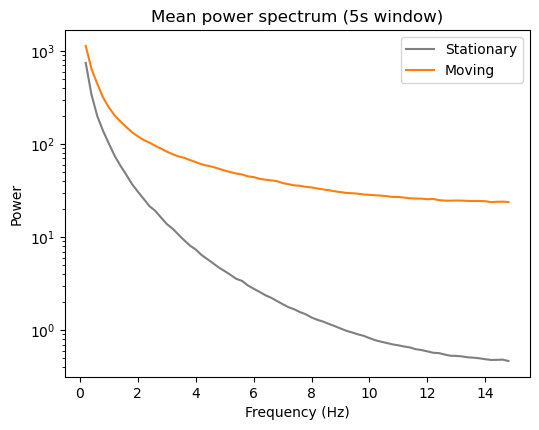

In [8]:
mean_moving_psd_all = []
mean_stationary_psd_all = []
sd_moving_psd_all = []
sd_stationary_psd_all = []

for win_idx, (moving_stim_psd, stationary_stim_psd, frequencies) in enumerate(zip(moving_stim_psd_all, stationary_stim_psd_all, frequencies_all)):
    mean_moving_psd = np.mean(moving_stim_psd, axis=(0, 1, 2, 3, 4, 5))
    mean_stationary_psd = np.mean(stationary_stim_psd, axis=(0, 1, 2, 3, 4, 5))
    sd_moving_psd = np.std(moving_stim_psd, axis=(0, 1, 2, 3, 4, 5))
    sd_stationary_psd = np.std(stationary_stim_psd, axis=(0, 1, 2, 3, 4, 5))

    mean_moving_psd_all.append(mean_moving_psd)
    mean_stationary_psd_all.append(mean_stationary_psd)
    sd_moving_psd_all.append(sd_moving_psd)
    sd_stationary_psd_all.append(sd_stationary_psd)

    # Plot and save
    fig, ax = plt.subplots(1, 1, figsize=(4*1.5, 3*1.5))
    ax.plot(frequencies[1:-1], mean_stationary_psd[1:-1], label='Stationary', color='tab:gray')
    ax.plot(frequencies[1:-1], mean_moving_psd[1:-1], label='Moving', color='tab:orange')
    # Optionally add SD shading:
    # ax.fill_between(frequencies[1:-1], mean_stationary_psd[1:-1] - sd_stationary_psd[1:-1], mean_stationary_psd[1:-1] + sd_stationary_psd[1:-1], color='tab:gray', alpha=0.2)
    # ax.fill_between(frequencies[1:-1], mean_moving_psd[1:-1] - sd_moving_psd[1:-1], mean_moving_psd[1:-1] + sd_moving_psd[1:-1], color='tab:orange', alpha=0.2)
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Power')
    ax.set_title(f'Mean power spectrum ({window_lengths_sec[win_idx]}s window)')
    ax.set_yscale('log')
    ax.legend()
    plt.savefig(f'../manuscript_figures/fig3_psd_mean_full_window_{window_lengths_sec[win_idx]}s.pdf', format='pdf', bbox_inches='tight')
    plt.show()
    plt.close(fig)

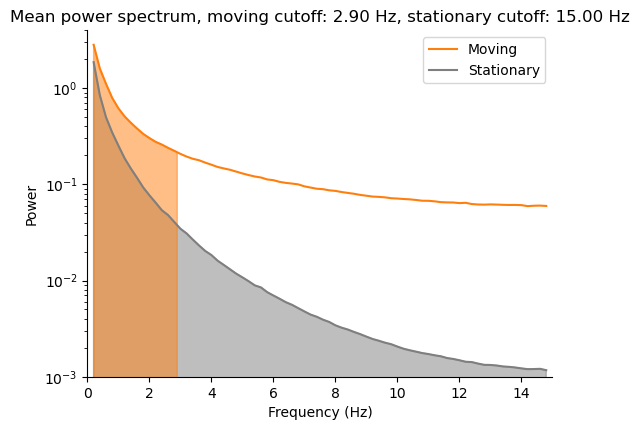

In [26]:
# compute the average spectrum over all filters
# plot the mean spectrum
fig, ax = plt.subplots(1, 1, figsize=(4*1.5, 3*1.5))
ax.plot(frequencies[1:-1], mean_moving_psd[1:-1], label='Moving', color='tab:orange')
ax.plot(frequencies[1:-1], mean_stationary_psd[1:-1], label='Stationary', color='tab:gray')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power')
ax.set_yscale('log')
# ax.set_xscale('log')
ax.legend()

# find where the area under the stationary psd is a certain value
# auc_val = 1
# aoc_idx_stat = np.where(np.cumsum(mean_stationary_psd*freq_spacing) <= auc_val)[0][-1]
# # find the frequency at that index
# freq_val_stat = frequencies[aoc_idx_stat]
# auc_idx_mov = np.where(np.cumsum(mean_moving_psd*freq_spacing) <= auc_val)[0][-1]
# # find the frequency at that index
# freq_val_mov = frequencies[auc_idx_mov]

auc_val_stat = 1
auc_val_mov = 2
cum_stationary = np.cumsum(mean_stationary_psd * freq_spacing)
cum_moving = np.cumsum(mean_moving_psd * freq_spacing)

# Interpolate to find the frequency where the cumulative sum reaches auc_val
freq_val_stat = np.interp(auc_val_stat, cum_stationary, frequencies)
freq_val_mov = np.interp(auc_val_mov, cum_moving, frequencies)

# # plot filled area under the curve
# ax.fill_between(frequencies[1:-1], mean_stationary_psd[1:-1], where=(frequencies[1:-1] <= freq_val_stat), color='tab:gray', alpha=0.5)
# ax.fill_between(frequencies[1:-1], mean_moving_psd[1:-1], where=(frequencies[1:-1] <= freq_val_mov), color='tab:orange', alpha=0.5)

# Interpolate the PSD at the cutoff frequencies
psd_val_stat = np.interp(freq_val_stat, frequencies, mean_stationary_psd)
psd_val_mov = np.interp(freq_val_mov, frequencies, mean_moving_psd)

# For fill_between, extend the frequency and PSD arrays to include the interpolated cutoff point
def extend_for_fill(frequencies, psd, cutoff_freq, cutoff_psd):
    mask = frequencies <= cutoff_freq
    # Find the last index before the cutoff
    last_idx = np.where(mask)[0][-1]
    # Insert the cutoff point after last_idx
    new_freqs = np.insert(frequencies[mask], last_idx + 1, cutoff_freq)
    new_psd = np.insert(psd[mask], last_idx + 1, cutoff_psd)
    return new_freqs, new_psd

freqs_stat_fill, psd_stat_fill = extend_for_fill(frequencies[1:-1], mean_stationary_psd[1:-1], freq_val_stat, psd_val_stat)
freqs_mov_fill, psd_mov_fill = extend_for_fill(frequencies[1:-1], mean_moving_psd[1:-1], freq_val_mov, psd_val_mov)

# plot filled area under the curve using the interpolated cutoff
ax.fill_between(freqs_stat_fill[:-1], psd_stat_fill[:-1], color='tab:gray', alpha=0.5)
ax.fill_between(freqs_mov_fill, psd_mov_fill, color='tab:orange', alpha=0.5)
ax.set_xlim(0, 15)
ax.set_ylim(1e-3, 4)
# remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title(f'Mean power spectrum, moving cutoff: {freq_val_mov:.2f} Hz, stationary cutoff: {freq_val_stat:.2f} Hz')


plt.savefig(f'../manuscript_figures/fig3_psd_mean_normalize_2Hz_crop_auc_stat_{auc_val_stat}_auc_mov_{auc_val_mov}.pdf', format='pdf', bbox_inches='tight')

In [9]:
# Normalize the spectrum for each window so that the area under the curve is 1
normalized_mean_stationary_psd_all = []
normalized_mean_moving_psd_all = []

for win_idx in range(len(window_sizes)):
    frequencies = frequencies_all[win_idx]
    mean_stationary_psd = mean_stationary_psd_all[win_idx]
    mean_moving_psd = mean_moving_psd_all[win_idx]
    freq_spacing = np.diff(frequencies)[0]
    norm_factor = np.sum(mean_stationary_psd * freq_spacing)
    mean_stationary_psd_norm = mean_stationary_psd / norm_factor
    mean_moving_psd_norm = mean_moving_psd / norm_factor
    normalized_mean_stationary_psd_all.append(mean_stationary_psd_norm)
    normalized_mean_moving_psd_all.append(mean_moving_psd_norm)

In [10]:
# Repeat the process for a range of theta values for each window size
num_theta_values = 1000
theta_values = np.linspace(0, 15, num_theta_values)

all_moving_stim_energy = []
all_stationary_stim_energy = []

for win_idx in range(len(window_sizes)):
    frequencies = frequencies_all[win_idx]
    mean_stationary_psd = normalized_mean_stationary_psd_all[win_idx]
    mean_moving_psd = normalized_mean_moving_psd_all[win_idx]
    freq_spacing = np.diff(frequencies)[0]
    moving_stim_energy = np.zeros(num_theta_values)
    stationary_stim_energy = np.zeros(num_theta_values)
    for i in tqdm(range(num_theta_values), desc=f"Window {window_lengths_sec[win_idx]}s"):
        # compute the filter
        filter = temporal_filter(frequencies, theta_values[i])
        # compute the filtered spectra
        filtered_mean_stationary_psd = mean_stationary_psd * filter
        filtered_mean_moving_psd = mean_moving_psd * filter
        # compute the energy
        moving_stim_energy[i] = np.sum(filtered_mean_moving_psd * freq_spacing)
        stationary_stim_energy[i] = np.sum(filtered_mean_stationary_psd * freq_spacing)
    all_moving_stim_energy.append(moving_stim_energy)
    all_stationary_stim_energy.append(stationary_stim_energy)

Window 5s: 100%|██████████| 1000/1000 [00:00<00:00, 26932.66it/s]


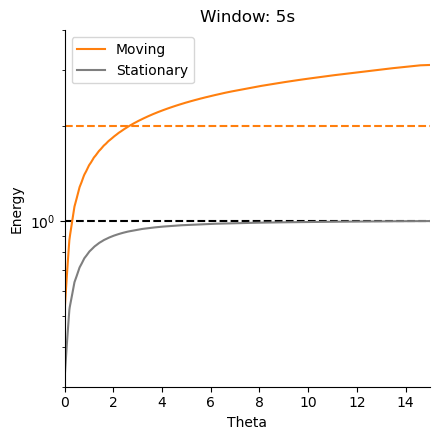

In [24]:
# Plot the energy vs. theta for each window size
fig, ax = plt.subplots(1, len(window_sizes), figsize=(3*1.5*len(window_sizes), 3*1.5))
if len(window_sizes) == 1:
    ax = [ax]
for win_idx in range(len(window_sizes)):
    ax[win_idx].axhline(1, color='k', linestyle='--')
    ax[win_idx].axhline(2, color='tab:orange', linestyle='--')
    ax[win_idx].plot(theta_values, all_moving_stim_energy[win_idx], label='Moving', color='tab:orange')
    ax[win_idx].plot(theta_values, all_stationary_stim_energy[win_idx], label='Stationary', color='tab:gray')
    ax[win_idx].set_xlabel('Theta')
    ax[win_idx].set_title(f'Window: {window_lengths_sec[win_idx]}s')
    ax[win_idx].set_yscale('log')
    ax[win_idx].set_xlim(0, 15)
    ax[win_idx].set_ylim(.3, 4)
    # remove the right and top spines
    ax[win_idx].spines['right'].set_visible(False)
    ax[win_idx].spines['top'].set_visible(False)
    if win_idx == 0:
        ax[win_idx].set_ylabel('Energy')
    ax[win_idx].legend()
plt.tight_layout()
plt.savefig(f'../manuscript_figures/fig3_energy_vs_theta_filtered.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [17]:
freq_val_stat - freq_val_mov

12.324262527308106

### Full 2D optimization

In [ ]:
relative = True

# for given energy capacities in the stationary case (between 0 and 1)
energy_capacity_stat = np.linspace(0, 1, 101)
# energy_capacity_mov = np.linspace(0, 2, 101)
delta_energy_capacity = np.linspace(0.01, 10, 1000)
# energy_capacity_stat = np.logspace(-1, 0, 100)
# delta_energy_capacity = np.logspace(-1, 1, 101)

# interpolate the energy values to get a smooth curve
stationary_theta_interp = np.interp(energy_capacity_stat, stationary_stim_energy, theta_values)

if relative:
    energy_capacity_mov = np.outer(delta_energy_capacity, energy_capacity_stat) + energy_capacity_stat[np.newaxis, :] # relative
    delta_energy_capacity *= 100 # convert to percent
else:
    energy_capacity_mov = delta_energy_capacity[:, np.newaxis] + energy_capacity_stat[np.newaxis, :] # absolute

moving_theta_interp = np.interp(energy_capacity_mov, moving_stim_energy, theta_values)


In [ ]:
import matplotlib.colors as mcolors
from matplotlib import cm

norm = mcolors.Normalize(vmin=np.min(theta_values), vmax=np.max(theta_values))
two_color_norm = mcolors.TwoSlopeNorm(vmin=-5, vcenter=0, vmax=5)

# example_points = [(50, 50), (75, 75), (95, 100)]
example_points = [(75, 9), (90, 19), (95, 29), (99, 49)]

fig, ax = plt.subplots(1, 3, figsize=(16, 5), width_ratios=[5, 5, 5], sharey=True)
im0 = ax[0].imshow(np.repeat(stationary_theta_interp[np.newaxis, :], len(delta_energy_capacity), axis=0), origin='lower', norm=norm, cmap='gray_r', extent=[energy_capacity_stat[0], energy_capacity_stat[-1], delta_energy_capacity[0], delta_energy_capacity[-1]], aspect='auto')
ax[0].set_title('Stationary theta')
im1 = ax[1].imshow(moving_theta_interp, origin='lower', norm=norm, cmap='gray_r', extent=[energy_capacity_stat[0], energy_capacity_stat[-1], delta_energy_capacity[0], delta_energy_capacity[-1]], aspect='auto')
ax[1].set_title('Moving theta')
colors_map = mcolors.LinearSegmentedColormap.from_list('custom_cmap', [(1, 127/255, 14/255), (1, 1, 1), (0.5, 0.5, 0.5)], N=256)
im2 = ax[2].imshow(stationary_theta_interp[np.newaxis, :]-moving_theta_interp, origin='lower', norm=two_color_norm, cmap=colors_map, extent=[energy_capacity_stat[0], energy_capacity_stat[-1], delta_energy_capacity[0], delta_energy_capacity[-1]], aspect='auto')
ax[2].set_title('Difference in theta [stationary - moving]')
# ax[2].set_xlim(0.5, 1)
# ax[2].set_ylim(0.5, 1)
# add axis labels
if relative:
    ax[0].set_ylabel('Percentage increase in energy capacity')
else:
    ax[0].set_ylabel('Increase in energy capacity')

fig.supxlabel('Energy capacity')

# plot the example points in three different colors which are distinct from red, white and blue
colors_map = cm.get_cmap('Blues', len(example_points)+2)
# plot the example points in the first subplot
for i, point in enumerate(example_points):
    ax[0].scatter(energy_capacity_stat[point[0]], delta_energy_capacity[point[1]], color=colors_map(i+1), s=100, edgecolor='black', label='Example point ' + str(i+1))
    ax[1].scatter(energy_capacity_stat[point[0]], delta_energy_capacity[point[1]], color=colors_map(i+1), s=100, edgecolor='black')
    ax[2].scatter(energy_capacity_stat[point[0]], delta_energy_capacity[point[1]], color=colors_map(i+1), s=100, edgecolor='black')

ax[0].set_yscale('log')

# add a colorbar without disrupting the layout of the other subplots
cbar = fig.colorbar(im2, ax=ax[2], orientation='vertical', pad=0.04)
cbar = fig.colorbar(im1, ax=ax[1], orientation='vertical', pad=0.04)
cbar = fig.colorbar(im0, ax=ax[0], orientation='vertical', pad=0.04)
plt.savefig(f'../manuscript_figures/fig3_diff_theta_stat_energy_vs_delta_energy_{window_lengths_sec[win_idx]}s.pdf', format='pdf', bbox_inches='tight')

TypeError: 'int' object is not subscriptable

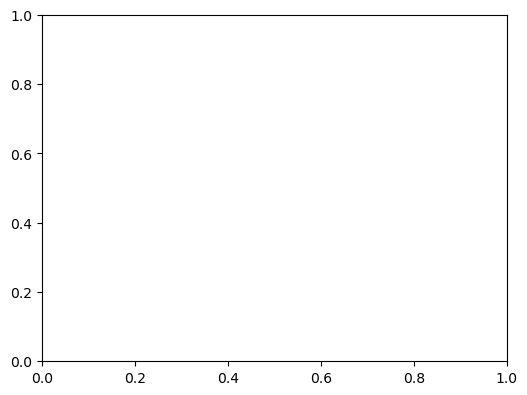

In [86]:
from scipy.fft import irfft

# compute the autocorrelation function for the example points by extracting the theta values in the stationary and moving conditions and then applying the filter to white noise and then computing the autocorrelation function as the inverse fourier transform of the PSD
alpha_arr = [0.25, 0.5, 0.75, 1]
fig, ax = plt.subplots(1, 1, figsize=(4*1.5, 3*1.5))
for i in range(len(example_points)):
    # compute the filter
    example_theta_mov = moving_theta_interp[example_points[i][1], example_points[i][0]]
    example_theta_stat = stationary_theta_interp[example_points[i][0]]
    # compute the filter
    example_filter_mov = temporal_filter(frequencies, example_theta_mov)
    example_filter_stat = temporal_filter(frequencies, example_theta_stat)
    # compute the inverse fourier transform
    example_moving_autocorr = irfft(example_filter_mov/freq_spacing)
    example_stationary_autocorr = irfft(example_filter_stat/freq_spacing)
    # normalize the autocorrelation function
    example_moving_autocorr /= np.max(example_moving_autocorr)
    example_stationary_autocorr /= np.max(example_stationary_autocorr)
    # plot the autocorrelation function
    time = np.arange(0, len(example_moving_autocorr)) / 30*1000
    ax.plot(time, example_moving_autocorr, label='Moving', color='tab:orange', alpha=alpha_arr[i])
    ax.plot(time, example_stationary_autocorr, label='Stationary', color='tab:gray', alpha=alpha_arr[i])
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Autocorrelation')
    # ax.legend()
    ax.set_xlim(0, 500)
plt.savefig(f'../manuscript_figures/fig3_autocorr_example_{i}_{window_lengths_sec[win_idx]}s.pdf', format='pdf', bbox_inches='tight')
plt.show()
plt.close(fig)

### 1D optimization

In [12]:
# Repeat for all windows, but keep energy_capacity_stat fixed at 1

relative = True

energy_capacity_stat = 1.0  # Always use 1 for stationary energy capacity
delta_energy_capacity = np.linspace(0.01, 3, 300)

all_stationary_theta_interp = []
all_moving_theta_interp = []

for win_idx in range(len(window_sizes)):
    stationary_stim_energy = all_stationary_stim_energy[win_idx]
    moving_stim_energy = all_moving_stim_energy[win_idx]
    # theta_values should be defined as before
    # If not, use: theta_values = np.linspace(0, 15, stationary_stim_energy.shape[0])

    # Interpolate stationary theta for energy_capacity_stat = 1
    stationary_theta_interp = np.interp(energy_capacity_stat, stationary_stim_energy, theta_values)

    if relative:
        energy_capacity_mov = delta_energy_capacity*energy_capacity_stat + energy_capacity_stat  # relative to stat
        delta_energy_capacity_scaled = delta_energy_capacity * 100  # percent
    else:
        energy_capacity_mov = delta_energy_capacity + energy_capacity_stat  # absolute

    # Interpolate moving theta for each delta
    moving_theta_interp = np.interp(energy_capacity_mov, moving_stim_energy, theta_values)

    all_stationary_theta_interp.append(stationary_theta_interp)
    all_moving_theta_interp.append(moving_theta_interp)

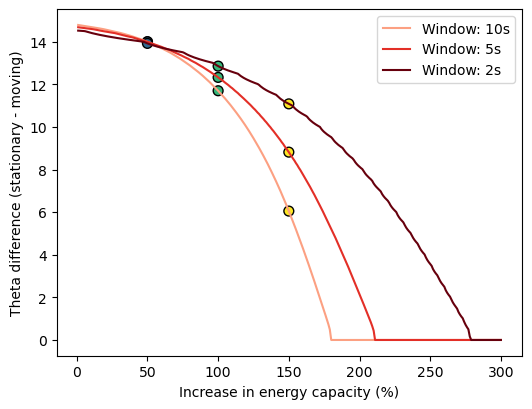

In [151]:
import matplotlib.colors as mcolors
from matplotlib import cm

# example_points = [(50, 50), (75, 75), (95, 100)]
example_points = [49, 99, 149]

fig, ax = plt.subplots(1, 1, figsize=(4*1.5, 3*1.5))
for win_idx in range(len(window_lengths_sec)):
    ax.plot(delta_energy_capacity*100, all_stationary_theta_interp[win_idx]-all_moving_theta_interp[win_idx], label='Window: ' + str(window_lengths_sec[win_idx]) + 's', color=cm.Reds((win_idx+1)/len(window_lengths_sec)))
    ax.scatter(delta_energy_capacity[example_points]*100, all_stationary_theta_interp[win_idx]-all_moving_theta_interp[win_idx][example_points], color=cm.viridis((np.arange(len(example_points))+1)/len(example_points)), s=50, edgecolor='black')
ax.set_xlabel('Increase in energy capacity (%)')
ax.set_ylabel('Theta difference (stationary - moving)')
ax.legend()

plt.savefig(f'../manuscript_figures/fig3_diff_theta_fixed_stat_energy_vs_delta_energy_{window_lengths_sec[win_idx]}s.pdf', format='pdf', bbox_inches='tight')

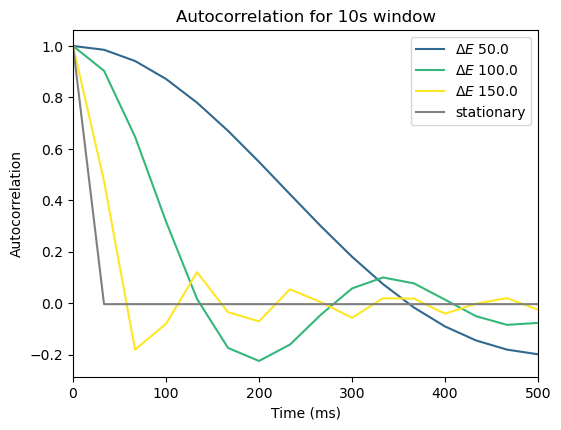

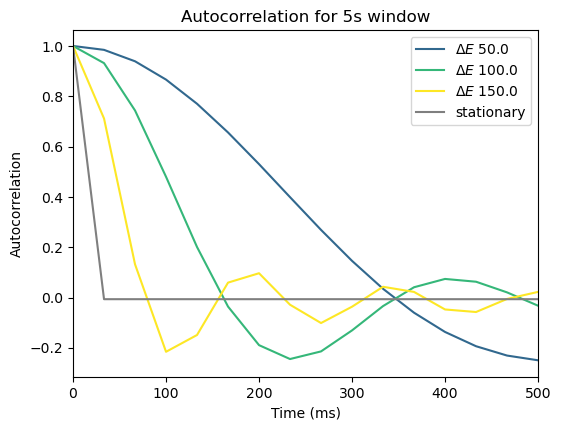

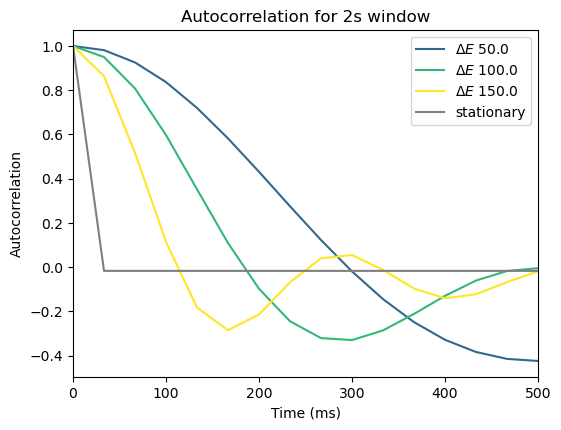

In [152]:
from scipy.fft import irfft

# Repeat for each window size
alpha_arr = [0.25, 0.5, 0.75, 1]
for win_idx in range(len(window_sizes)):
    frequencies = frequencies_all[win_idx]
    freq_spacing = np.diff(frequencies)[0]
    stationary_theta_interp = all_stationary_theta_interp[win_idx]
    moving_theta_interp = all_moving_theta_interp[win_idx]
    fig, ax = plt.subplots(1, 1, figsize=(4*1.5, 3*1.5))
    for i in range(len(example_points)):
        # compute the filter
        example_theta_mov = moving_theta_interp[example_points[i]]
        example_theta_stat = stationary_theta_interp
        # compute the filter
        example_filter_mov = temporal_filter(frequencies, example_theta_mov)
        example_filter_stat = temporal_filter(frequencies, example_theta_stat)
        # set the DC to zero
        example_filter_mov[0] = 0
        example_filter_stat[0] = 0
        # compute the inverse fourier transform
        example_moving_autocorr = irfft(example_filter_mov)
        example_stationary_autocorr = irfft(example_filter_stat)
        # normalize the autocorrelation function
        example_moving_autocorr /= np.max(example_moving_autocorr)
        example_stationary_autocorr /= np.max(example_stationary_autocorr)
        # plot the autocorrelation function
        time = np.arange(0, len(example_moving_autocorr)) / 30*1000
        ax.plot(time, example_moving_autocorr, color=cm.viridis((np.arange(len(example_points))+1)/len(example_points))[i], label=f'$\\Delta E$ {delta_energy_capacity[example_points[i]]*100}')
        ax.set_xlabel('Time (ms)')
        ax.set_ylabel('Autocorrelation')
        ax.set_title(f'Autocorrelation for {window_lengths_sec[win_idx]}s window')
        ax.set_xlim(0, 500)
    ax.plot(time, example_stationary_autocorr, color='tab:gray', label='stationary')
    ax.legend()
    plt.savefig(f'../manuscript_figures/fig3_autocorr_{window_lengths_sec[win_idx]}s.pdf', format='pdf', bbox_inches='tight')
    plt.show()
    plt.close(fig)

### Individual filters

In [153]:
# Repeat the normalization and energy computation for all window sizes
all_moving_stim_energy = []
all_stationary_stim_energy = []

num_theta_values = 1000
theta_values = np.linspace(0, 15, num_theta_values)

all_stationary_theta_interp = []
all_moving_theta_interp = []

num_energy_levels = 100
energy_capacity_stat = np.linspace(0, 1, num_energy_levels+1)
delta_energy_capacity = np.linspace(0.01, 10, 10*num_energy_levels)
relative = True

for win_idx in range(len(window_sizes)):
    stationary_stim_psd_avg = stationary_stim_psd_avg_all[win_idx]
    moving_stim_psd_avg = moving_stim_psd_avg_all[win_idx]
    # Use the correct frequency array for this window size
    frequencies = frequencies_all[win_idx]
    freq_spacing = np.diff(frequencies)[0]

    # Normalize the spectrum such that the area under the curve is 1
    norm_factor = np.sum(stationary_stim_psd_avg * freq_spacing, axis=-1, keepdims=True)
    stationary_stim_psd_avg_norm = stationary_stim_psd_avg / norm_factor
    moving_stim_psd_avg_norm = moving_stim_psd_avg / norm_factor

    mat_shape = stationary_stim_psd_avg_norm.shape

    # Compute energy for a range of theta values
    moving_stim_energy = np.zeros((*mat_shape[:-1], num_theta_values))
    stationary_stim_energy = np.zeros((*mat_shape[:-1], num_theta_values))
    for i in tqdm(range(num_theta_values), desc=f"Window {window_lengths_sec[win_idx]}s"):
        filter = temporal_filter(frequencies, theta_values[i])
        filtered_mean_stationary_psd = stationary_stim_psd_avg_norm * filter
        filtered_mean_moving_psd = moving_stim_psd_avg_norm * filter
        moving_stim_energy[:, :, :, :, i] = np.sum(filtered_mean_moving_psd * freq_spacing, axis=-1)
        stationary_stim_energy[:, :, :, :, i] = np.sum(filtered_mean_stationary_psd * freq_spacing, axis=-1)
    all_moving_stim_energy.append(moving_stim_energy)
    all_stationary_stim_energy.append(stationary_stim_energy)

     # --- Interpolation block (from your prompt) ---
    if relative:
        energy_capacity_mov = np.outer(delta_energy_capacity, energy_capacity_stat) + energy_capacity_stat[np.newaxis, :]
        delta_energy_capacity_scaled = delta_energy_capacity * 100  # convert to percent
    else:
        energy_capacity_mov = delta_energy_capacity[:, np.newaxis] + energy_capacity_stat[np.newaxis, :]
    stationary_theta_interp = np.zeros((num_energy_levels+1, *mat_shape[:-1]))
    moving_theta_interp = np.zeros((10*num_energy_levels, num_energy_levels+1, *mat_shape[:-1]))

    for i in range(mat_shape[0]):
        for j in range(mat_shape[1]):
            for k in range(mat_shape[2]):
                for l in range(mat_shape[3]):
                    stationary_theta_interp[:, i, j, k, l] = np.interp(
                        energy_capacity_stat, stationary_stim_energy[i, j, k, l], theta_values
                    )
                    for m in range(num_energy_levels):
                        moving_theta_interp[:, m, i, j, k, l] = np.interp(
                            energy_capacity_mov[:, m], moving_stim_energy[i, j, k, l], theta_values
                        )
    all_stationary_theta_interp.append(stationary_theta_interp)
    all_moving_theta_interp.append(moving_theta_interp)

Window 10s: 100%|██████████| 1000/1000 [00:26<00:00, 38.33it/s]


KeyboardInterrupt: 

In [ ]:
# For each window size, compute the cutoff value of the autocorrelation function for different points in the energy landscape

cutoff = 0.5
example_points = [(75, 9), (90, 19), (95, 29), (99, 49)]  # or use your own

all_cutoff_frequency_mov = []
all_cutoff_frequency_stat = []
all_autocorr_func_mov = []
all_autocorr_func_stat = []

for win_idx in range(len(all_stationary_theta_interp)):
    stationary_theta_interp = all_stationary_theta_interp[win_idx]
    moving_theta_interp = all_moving_theta_interp[win_idx]
    frequencies = frequencies_all[win_idx]
    mat_shape = stationary_theta_interp.shape[1:]  # (ori, phase, freq, pos)

    cutoff_frequency_mov = np.zeros((len(example_points), *mat_shape))
    cutoff_frequency_stat = np.zeros((len(example_points), *mat_shape))
    autocorr_func_mov = np.zeros((len(example_points), *mat_shape, 2*(len(frequencies)-1)))
    autocorr_func_stat = np.zeros((len(example_points), *mat_shape, 2*(len(frequencies)-1)))

    for m, (stat_idx, mov_idx) in enumerate(example_points):
        for i in range(mat_shape[0]):
            for j in range(mat_shape[1]):
                for k in range(mat_shape[2]):
                    for l in range(mat_shape[3]):
                        # Get theta values for this filter and energy point
                        example_theta_stat = stationary_theta_interp[stat_idx, i, j, k, l]
                        example_theta_mov = moving_theta_interp[mov_idx, stat_idx, i, j, k, l]
                        # Compute temporal filters
                        example_filter_stat = temporal_filter(frequencies, example_theta_stat)
                        example_filter_mov = temporal_filter(frequencies, example_theta_mov)
                        example_filter_stat[0] = 0
                        example_filter_mov[0] = 0
                        # Compute autocorrelation (inverse FFT of filter)
                        example_stationary_autocorr = irfft(example_filter_stat)
                        example_moving_autocorr = irfft(example_filter_mov)
                        # Normalize
                        example_stationary_autocorr /= np.max(example_stationary_autocorr)
                        example_moving_autocorr /= np.max(example_moving_autocorr)
                        # Store
                        autocorr_func_stat[m, i, j, k, l, :] = example_stationary_autocorr
                        autocorr_func_mov[m, i, j, k, l, :] = example_moving_autocorr
                        # Find cutoff
                        try:
                            cutoff_frequency_stat[m, i, j, k, l] = np.where(example_stationary_autocorr < cutoff)[0][0]
                        except IndexError:
                            cutoff_frequency_stat[m, i, j, k, l] = len(example_stationary_autocorr)
                        try:
                            cutoff_frequency_mov[m, i, j, k, l] = np.where(example_moving_autocorr < cutoff)[0][0]
                        except IndexError:
                            cutoff_frequency_mov[m, i, j, k, l] = len(example_moving_autocorr)
    all_cutoff_frequency_mov.append(cutoff_frequency_mov)
    all_cutoff_frequency_stat.append(cutoff_frequency_stat)
    all_autocorr_func_mov.append(autocorr_func_mov)
    all_autocorr_func_stat.append(autocorr_func_stat)

# Now all_cutoff_frequency_mov, all_cutoff_frequency_stat, all_autocorr_func_mov, all_autocorr_func_stat
# are lists, one per window size, containing the results for each window.

In [ ]:
# Plot the average autocorrelation function for each point and window size
for win_idx in range(len(all_autocorr_func_mov)):
    avg_autocorr_func_mov = np.mean(all_autocorr_func_mov[win_idx], axis=(1, 2, 3, 4))
    avg_autocorr_func_stat = np.mean(all_autocorr_func_stat[win_idx], axis=(1, 2, 3, 4))
    std_autocorr_func_mov = np.std(all_autocorr_func_mov[win_idx], axis=(1, 2, 3, 4))
    std_autocorr_func_stat = np.std(all_autocorr_func_stat[win_idx], axis=(1, 2, 3, 4))
    # Use the correct time axis for this window size
    time = np.arange(0, avg_autocorr_func_mov.shape[1]) / 30 * 1000
    for point_idx in range(len(example_points)):
        fig, ax = plt.subplots(1, 1, figsize=(4*1.5, 3*1.5))
        ax.plot(time, avg_autocorr_func_mov[point_idx, :], label='Moving', color='tab:orange')
        ax.plot(time, avg_autocorr_func_stat[point_idx, :], label='Stationary', color='tab:gray')
        ax.fill_between(
            time,
            avg_autocorr_func_mov[point_idx, :] - std_autocorr_func_mov[point_idx, :],
            avg_autocorr_func_mov[point_idx, :] + std_autocorr_func_mov[point_idx, :],
            color='tab:orange', alpha=0.2
        )
        ax.fill_between(
            time,
            avg_autocorr_func_stat[point_idx, :] - std_autocorr_func_stat[point_idx, :],
            avg_autocorr_func_stat[point_idx, :] + std_autocorr_func_stat[point_idx, :],
            color='tab:gray', alpha=0.2
        )
        ax.set_xlim(0, 500)
        ax.set_ylim(-1, 1)
        ax.set_title(f'Window size: {window_lengths_sec[win_idx]}s, Point {point_idx}')
        plt.savefig(f'../manuscript_figures/fig3_avg_autocorr_point_{point_idx}_window_{window_lengths_sec[win_idx]}s.pdf', format='pdf', bbox_inches='tight')
        plt.show()
        plt.close(fig)

# ...existing code...

In [ ]:
all_cutoff_frequency_mov = np.array(all_cutoff_frequency_mov)
all_cutoff_frequency_stat = np.array(all_cutoff_frequency_stat)
all_cutoff_frequency_stat = all_cutoff_frequency_stat / 30 * 1000
all_cutoff_frequency_mov = all_cutoff_frequency_mov / 30 * 1000
diff_cutoff_frequency = all_cutoff_frequency_mov - all_cutoff_frequency_stat

In [ ]:
# take the difference in cutoffs and plot the histogram
bins = np.linspace(-300, 300, 20)

window_idx = 3
point_idx = 3

for window_idx in range(len(window_sizes)):
    for point_idx in range(len(example_points)):
        fig, ax = plt.subplots(1, 1, figsize=(4*1.5, 3*1.5))
        ax.hist(diff_cutoff_frequency[window_idx, point_idx].flatten(), bins=bins, density=True)
        ax.set_xlabel('Difference of cutoff (moving - stationary) in ms')
        ax.axvline(np.mean(diff_cutoff_frequency[window_idx, point_idx]), color='k', linestyle='--')
        ax.set_title(f'Window size: {window_sizes[window_idx]/30}s, Point {point_idx}')
        plt.savefig(f'../manuscript_figures/fig3_hist_cutoff_diff_theory_window_{window_sizes[window_idx]}_point_{point_idx}.pdf', format='pdf', bbox_inches='tight')
        plt.show()
        plt.close(fig)

In [ ]:
diff_cutoff_frequency.shape

In [ ]:
avg_diff_cutoff_frequency = np.mean(diff_cutoff_frequency, axis=(2, 3, 4, 5))
median_diff_cutoff_frequency = np.median(diff_cutoff_frequency, axis=(2, 3, 4, 5))

In [ ]:
norm = mcolors.TwoSlopeNorm(vmin=-100, vcenter=0, vmax=100)
energy_capacity_stat = np.linspace(0, 1, num_energy_levels+1)
delta_energy_capacity = np.linspace(0.01, 10, 10*num_energy_levels)

im = plt.imshow(avg_diff_cutoff_frequency.T, norm=norm, cmap='bwr', aspect='auto')
plt.xticks(np.arange(len(window_sizes)), np.array(window_sizes)/30)
plt.xlabel('Window size (s)')
plt.ylabel('Constraint point')
plt.yticks(np.arange(len(example_points)), [f'$E_s$ {energy_capacity_stat[example_points[i][0]]:.2f}\n$\\Delta E$ {delta_energy_capacity[example_points[i][1]]:.2f}' for i in range(len(example_points))])
plt.colorbar(im, label='moving cutoff - stationary cutoff (ms)')
plt.suptitle('Average difference in cutoff frequency for different energy constraints')
plt.savefig(f'../manuscript_figures/fig3_avg_diff_cutoff_frequency.pdf', format='pdf', bbox_inches='tight')


In [ ]:
norm = mcolors.TwoSlopeNorm(vmin=-100, vcenter=0, vmax=100)
energy_capacity_stat = np.linspace(0, 1, num_energy_levels+1)
delta_energy_capacity = np.linspace(0.01, 10, 10*num_energy_levels)

im = plt.imshow(median_diff_cutoff_frequency.T, norm=norm, cmap='bwr', aspect='auto')
plt.xticks(np.arange(len(window_sizes)), np.array(window_sizes)/30)
plt.xlabel('Window size (s)')
plt.ylabel('Constraint point')
plt.yticks(np.arange(len(example_points)), [f'$E_s$ {energy_capacity_stat[example_points[i][0]]:.2f}\n$\\Delta E$ {delta_energy_capacity[example_points[i][1]]:.2f}' for i in range(len(example_points))])
plt.colorbar(im, label='moving cutoff - stationary cutoff (ms)')
plt.suptitle('Median difference in cutoff frequency for different energy constraints')
plt.savefig(f'../manuscript_figures/fig3_median_diff_cutoff_frequency.pdf', format='pdf', bbox_inches='tight')


#### 1D optimization

In [13]:
# Repeat the normalization and energy computation for all window sizes
all_moving_stim_energy = []
all_stationary_stim_energy = []

num_theta_values = 1000
theta_values = np.linspace(0, 15, num_theta_values)

all_stationary_theta_interp = []
all_moving_theta_interp = []

num_energy_levels = 30
energy_capacity_stat = 1.0
delta_energy_capacity = np.linspace(0.01, 3, 10*num_energy_levels)
relative = True

for win_idx in range(len(window_sizes)):
    stationary_stim_psd_avg = stationary_stim_psd_avg_all[win_idx]
    moving_stim_psd_avg = moving_stim_psd_avg_all[win_idx]
    # Use the correct frequency array for this window size
    frequencies = frequencies_all[win_idx]
    freq_spacing = np.diff(frequencies)[0]

    # Normalize the spectrum such that the area under the curve is 1
    norm_factor = np.sum(stationary_stim_psd_avg * freq_spacing, axis=-1, keepdims=True)
    stationary_stim_psd_avg_norm = stationary_stim_psd_avg / norm_factor
    moving_stim_psd_avg_norm = moving_stim_psd_avg / norm_factor

    mat_shape = stationary_stim_psd_avg_norm.shape

    # Compute energy for a range of theta values
    moving_stim_energy = np.zeros((*mat_shape[:-1], num_theta_values))
    stationary_stim_energy = np.zeros((*mat_shape[:-1], num_theta_values))
    for i in tqdm(range(num_theta_values), desc=f"Window {window_lengths_sec[win_idx]}s"):
        filter = temporal_filter(frequencies, theta_values[i])
        filtered_mean_stationary_psd = stationary_stim_psd_avg_norm * filter
        filtered_mean_moving_psd = moving_stim_psd_avg_norm * filter
        moving_stim_energy[:, :, :, :, i] = np.sum(filtered_mean_moving_psd * freq_spacing, axis=-1)
        stationary_stim_energy[:, :, :, :, i] = np.sum(filtered_mean_stationary_psd * freq_spacing, axis=-1)
    all_moving_stim_energy.append(moving_stim_energy)
    all_stationary_stim_energy.append(stationary_stim_energy)

     # --- Interpolation block (from your prompt) ---
    if relative:
        energy_capacity_mov = delta_energy_capacity*energy_capacity_stat + energy_capacity_stat  # relative to stat
        delta_energy_capacity_scaled = delta_energy_capacity * 100  # percent
    else:
        energy_capacity_mov = delta_energy_capacity[:, np.newaxis] + energy_capacity_stat[np.newaxis, :]
    stationary_theta_interp = np.zeros(mat_shape[:-1])
    moving_theta_interp = np.zeros((10*num_energy_levels, *mat_shape[:-1]))

    for i in range(mat_shape[0]):
        for j in range(mat_shape[1]):
            for k in range(mat_shape[2]):
                for l in range(mat_shape[3]):
                    stationary_theta_interp[i, j, k, l] = np.interp(
                        energy_capacity_stat, stationary_stim_energy[i, j, k, l], theta_values
                    )
                    moving_theta_interp[:, i, j, k, l] = np.interp(
                        energy_capacity_mov, moving_stim_energy[i, j, k, l], theta_values
                    )
    all_stationary_theta_interp.append(stationary_theta_interp)
    all_moving_theta_interp.append(moving_theta_interp)

Window 5s:   0%|          | 0/1000 [00:00<?, ?it/s]

Window 5s: 100%|██████████| 1000/1000 [00:11<00:00, 87.84it/s]


In [14]:
moving_theta_interp[49, 0, -1, :, 4]

array([ 0.        ,  0.        ,  0.        ,  0.03832813,  0.0929131 ,
        0.13399111,  0.16891428,  0.20896607,  0.29383264,  0.37582695,
        0.50116845,  0.64677407,  0.85066897,  1.11539227,  1.43192998,
        1.84232847,  2.33510495,  2.90438474,  3.56145682,  4.31030568,
        5.14833264,  6.03156582,  6.98079584,  8.00163346,  9.08858688,
       10.18663481, 11.272941  , 12.39171477, 13.51818043, 14.62572536,
       15.        ])

In [16]:
from scipy.fft import irfft

cutoff = 0.5
example_points = [49, 99, 149]  # or your own, for 1D fixed stationary energy

all_cutoff_frequency_mov = []
all_cutoff_frequency_stat = []
all_autocorr_func_mov = []
all_autocorr_func_stat = []

for win_idx in range(len(all_stationary_theta_interp)):
    stationary_theta_interp = all_stationary_theta_interp[win_idx]  # shape: (filters...)
    moving_theta_interp = all_moving_theta_interp[win_idx]          # shape: (delta_energy, filters...)
    frequencies = frequencies_all[win_idx]
    mat_shape = stationary_theta_interp.shape  # (ori, phase, freq, pos)

    cutoff_frequency_mov = np.zeros((len(example_points), *mat_shape))
    cutoff_frequency_stat = np.zeros((len(example_points), *mat_shape))
    autocorr_func_mov = np.zeros((len(example_points), *mat_shape, 2*(len(frequencies)-1)))
    autocorr_func_stat = np.zeros((len(example_points), *mat_shape, 2*(len(frequencies)-1)))

    for m, mov_idx in enumerate(example_points):
        for i in range(mat_shape[0]):
            for j in range(mat_shape[1]):
                for k in range(mat_shape[2]):
                    for l in range(mat_shape[3]):
                        # Get theta values for this filter and energy point
                        example_theta_stat = stationary_theta_interp[i, j, k, l]
                        example_theta_mov = moving_theta_interp[mov_idx, i, j, k, l]
                        # Compute temporal filters
                        example_filter_stat = temporal_filter(frequencies, example_theta_stat)
                        example_filter_mov = temporal_filter(frequencies, example_theta_mov)
                        example_filter_stat[0] = 0
                        example_filter_mov[0] = 0
                        # Compute autocorrelation (inverse FFT of filter)
                        example_stationary_autocorr = irfft(example_filter_stat)
                        example_moving_autocorr = irfft(example_filter_mov)
                        # Normalize
                        example_stationary_autocorr /= np.max(example_stationary_autocorr)
                        example_moving_autocorr /= np.max(example_moving_autocorr)
                        # Store
                        autocorr_func_stat[m, i, j, k, l, :] = example_stationary_autocorr
                        autocorr_func_mov[m, i, j, k, l, :] = example_moving_autocorr
                        # Find cutoff
                        try:
                            cutoff_frequency_stat[m, i, j, k, l] = np.where(example_stationary_autocorr < cutoff)[0][0]
                        except IndexError:
                            cutoff_frequency_stat[m, i, j, k, l] = len(example_stationary_autocorr)
                        try:
                            cutoff_frequency_mov[m, i, j, k, l] = np.where(example_moving_autocorr < cutoff)[0][0]
                        except IndexError:
                            cutoff_frequency_mov[m, i, j, k, l] = len(example_moving_autocorr)
    all_cutoff_frequency_mov.append(cutoff_frequency_mov)
    all_cutoff_frequency_stat.append(cutoff_frequency_stat)
    all_autocorr_func_mov.append(autocorr_func_mov)
    all_autocorr_func_stat.append(autocorr_func_stat)

In [32]:
# do a paired t-test on the cutoff frequencies for each point and window size
from scipy.stats import ttest_rel
mov_cutoff = all_cutoff_frequency_mov[0, 0]
stat_cutoff = all_cutoff_frequency_stat[0, 0]

t_stat, p_value = ttest_rel(mov_cutoff.flatten(), stat_cutoff.flatten())
print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: 53.19000252754909, P-value: 0.0


In [35]:
import sys
print(sys.float_info.min)

2.2250738585072014e-308


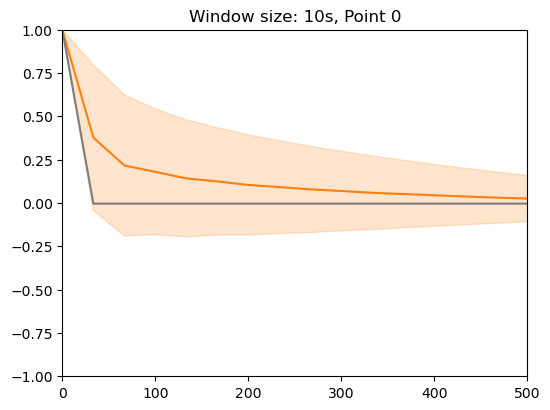

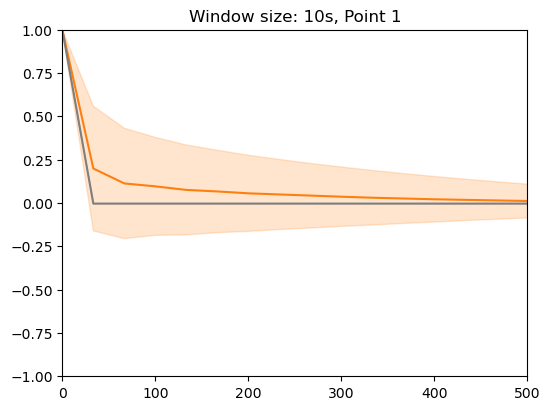

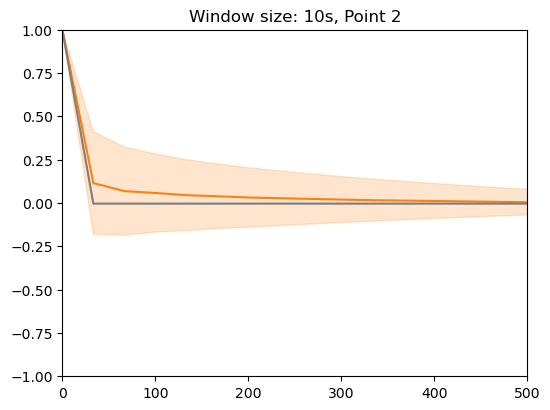

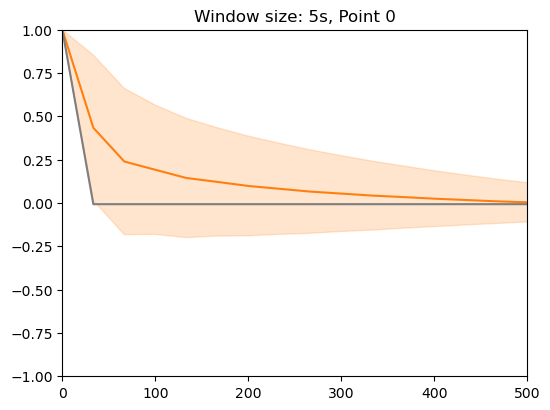

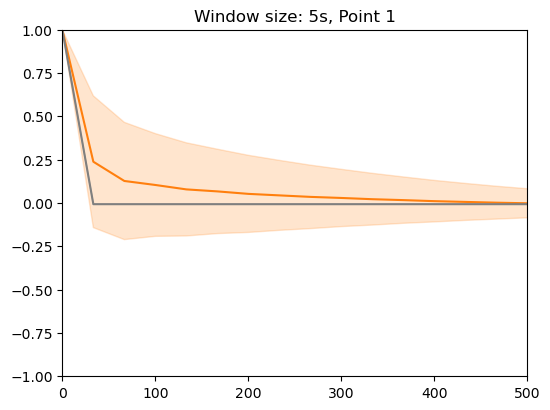

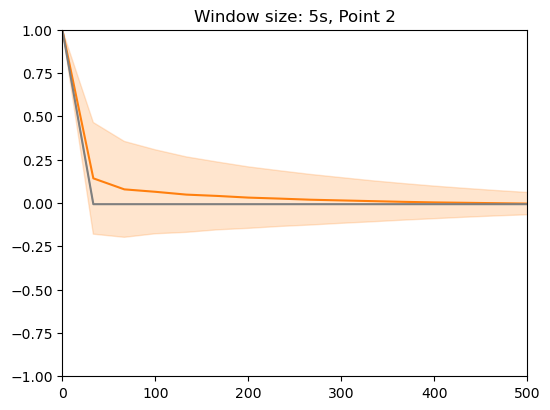

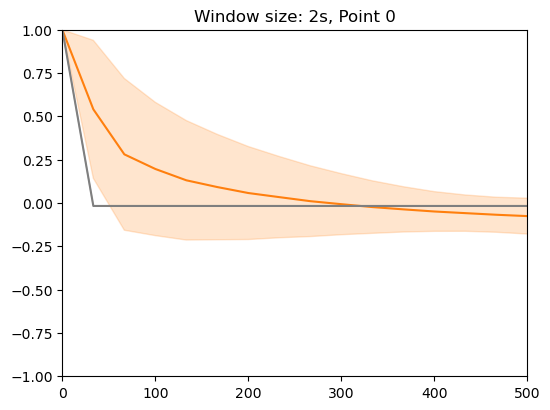

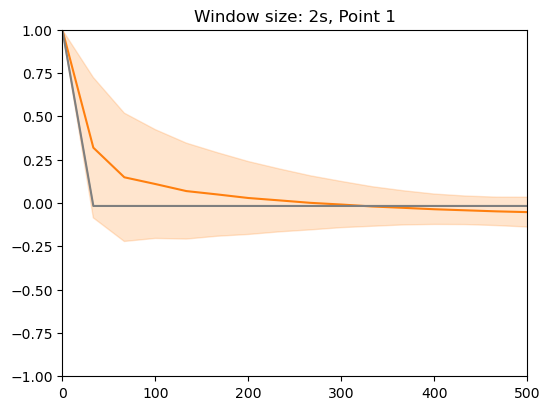

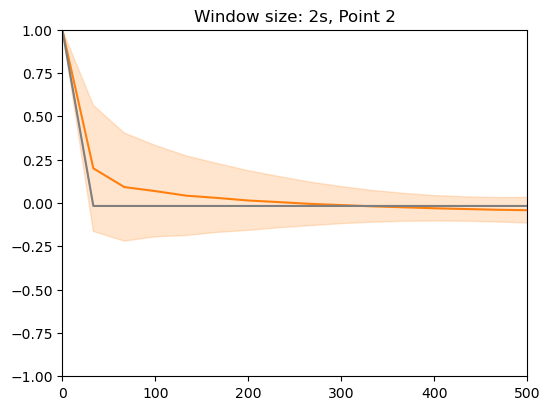

In [157]:
# Plot the average autocorrelation function for each point and window size
for win_idx in range(len(all_autocorr_func_mov)):
    avg_autocorr_func_mov = np.mean(all_autocorr_func_mov[win_idx], axis=(1, 2, 3, 4))
    avg_autocorr_func_stat = np.mean(all_autocorr_func_stat[win_idx], axis=(1, 2, 3, 4))
    std_autocorr_func_mov = np.std(all_autocorr_func_mov[win_idx], axis=(1, 2, 3, 4))
    std_autocorr_func_stat = np.std(all_autocorr_func_stat[win_idx], axis=(1, 2, 3, 4))
    # Use the correct time axis for this window size
    time = np.arange(0, avg_autocorr_func_mov.shape[1]) / 30 * 1000
    for point_idx in range(len(example_points)):
        fig, ax = plt.subplots(1, 1, figsize=(4*1.5, 3*1.5))
        ax.plot(time, avg_autocorr_func_mov[point_idx, :], label='Moving', color='tab:orange')
        ax.plot(time, avg_autocorr_func_stat[point_idx, :], label='Stationary', color='tab:gray')
        ax.fill_between(
            time,
            avg_autocorr_func_mov[point_idx, :] - std_autocorr_func_mov[point_idx, :],
            avg_autocorr_func_mov[point_idx, :] + std_autocorr_func_mov[point_idx, :],
            color='tab:orange', alpha=0.2
        )
        ax.fill_between(
            time,
            avg_autocorr_func_stat[point_idx, :] - std_autocorr_func_stat[point_idx, :],
            avg_autocorr_func_stat[point_idx, :] + std_autocorr_func_stat[point_idx, :],
            color='tab:gray', alpha=0.2
        )
        ax.set_xlim(0, 500)
        ax.set_ylim(-1, 1)
        ax.set_title(f'Window size: {window_lengths_sec[win_idx]}s, Point {point_idx}')
        plt.savefig(f'../manuscript_figures/fig3_avg_autocorr_point_{point_idx}_window_{window_lengths_sec[win_idx]}s.pdf', format='pdf', bbox_inches='tight')
        plt.show()
        plt.close(fig)

# ...existing code...

In [132]:
all_autocorr_func_mov[1].shape

(3, 8, 4, 31, 9, 150)

In [158]:
import os

# Directory to save figures
save_dir = "../manuscript_figures/autocorr_individual_corrected"
os.makedirs(save_dir, exist_ok=True)

# plot each individual autocorrelation function for a given windows size and position, for all example points, orientations, phases, and wavelengths
window_idx = 1 
position_idx = 4  # choose a position index, e.g., 0 for the first position
example_points = [49]  # or your own, for 1D fixed stationary energy
frequencies = frequencies_all[window_idx]
mat_shape = all_autocorr_func_mov[window_idx].shape[1:5]  # (ori, phase, freq, pos)

i = 0
point_idx = 49 
for ori_idx in range(mat_shape[0]):
    for phase_idx in range(mat_shape[1]):
        for freq_id in range(mat_shape[2]):
            fig, ax = plt.subplots(1, 1, figsize=(4*1.5, 3*1.5))
            ax.plot(
                np.arange(0, len(all_autocorr_func_mov[window_idx][i, ori_idx, phase_idx, freq_id, position_idx])) / 30 * 1000,
                all_autocorr_func_mov[window_idx][i, ori_idx, phase_idx, freq_id, position_idx],
                label='Moving', color='tab:orange'
            )
            ax.plot(
                np.arange(0, len(all_autocorr_func_stat[window_idx][i, ori_idx, phase_idx, freq_id, position_idx])) / 30 * 1000,
                all_autocorr_func_stat[window_idx][i, ori_idx, phase_idx, freq_id, position_idx],
                label='Stationary', color='tab:gray'
            )
            ax.set_xlim(0, 500)
            ax.set_ylim(-1, 1)
            ax.set_title(f'Window size: {window_lengths_sec[window_idx]}s\n$\\Delta E$ {delta_energy_capacity[point_idx]*100:.2f}, Ori {orientation_arr[ori_idx]:.2f}, Phase {phase_arr[phase_idx]:.2f}, Freq {freq_arr[freq_id]:.2f} cpd')
            ax.set_xlabel('Time (ms)')
            ax.set_ylabel('Autocorrelation')
            ax.legend()
            # Save figure
            fname = (
                f"autocorr_win{window_lengths_sec[window_idx]}s_point{point_idx}_"
                f"ori{ori_idx}_phase{phase_idx}_freq{freq_id}_pos{position_idx}.pdf"
            )
            plt.savefig(os.path.join(save_dir, fname), bbox_inches='tight', format='pdf')
            plt.close(fig)

In [30]:
all_cutoff_frequency_mov = np.array(all_cutoff_frequency_mov)
all_cutoff_frequency_stat = np.array(all_cutoff_frequency_stat)
all_cutoff_frequency_stat = all_cutoff_frequency_stat / 30 * 1000
all_cutoff_frequency_mov = all_cutoff_frequency_mov / 30 * 1000
diff_cutoff_frequency = all_cutoff_frequency_mov - all_cutoff_frequency_stat

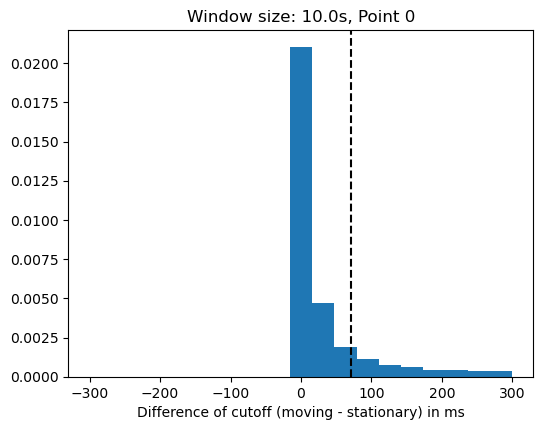

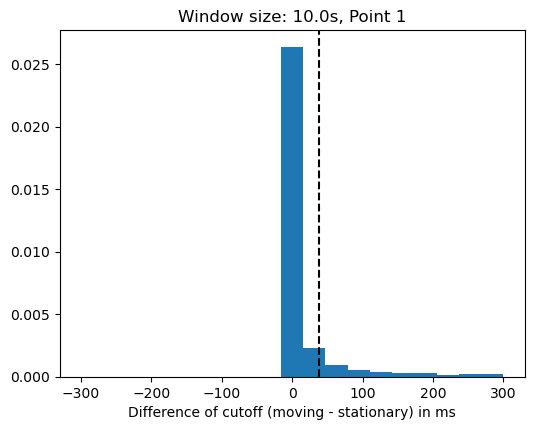

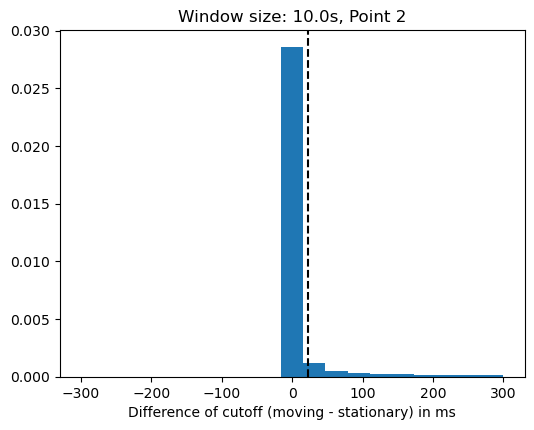

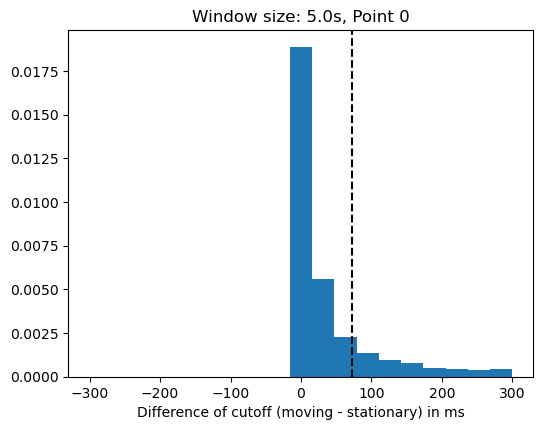

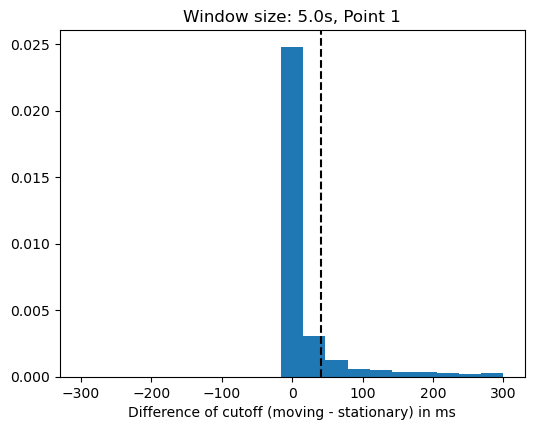

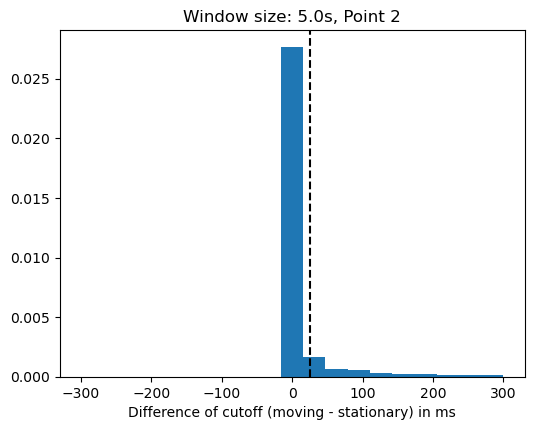

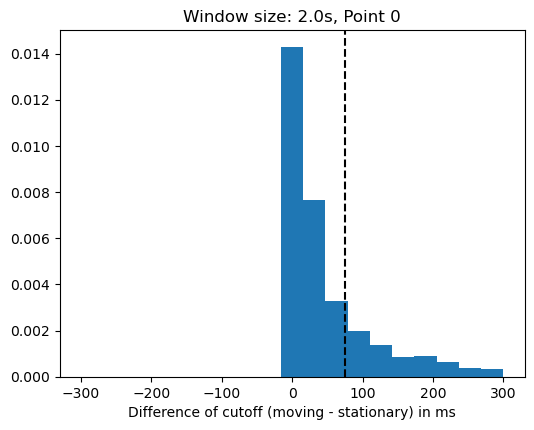

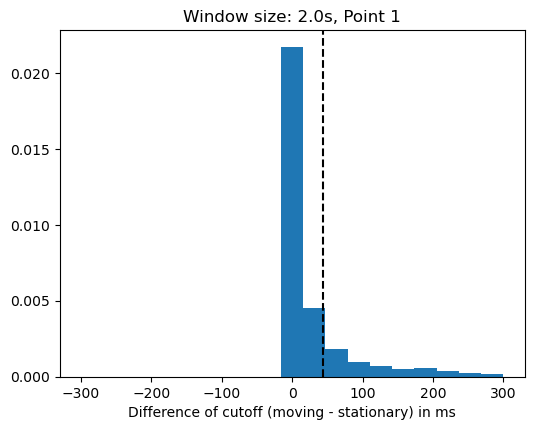

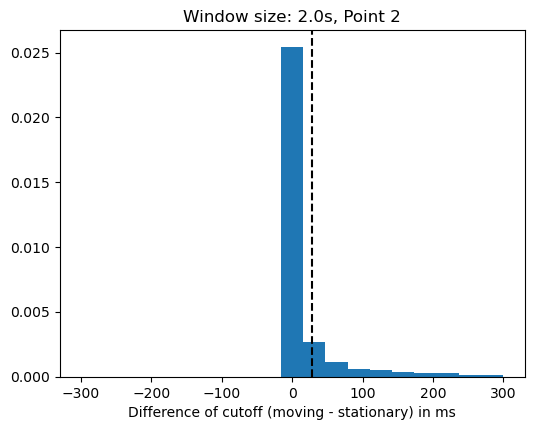

In [129]:
# take the difference in cutoffs and plot the histogram
bins = np.linspace(-300, 300, 20)

window_idx = 3
point_idx = 3

for window_idx in range(len(window_sizes)):
    for point_idx in range(len(example_points)):
        fig, ax = plt.subplots(1, 1, figsize=(4*1.5, 3*1.5))
        ax.hist(diff_cutoff_frequency[window_idx, point_idx].flatten(), bins=bins, density=True)
        ax.set_xlabel('Difference of cutoff (moving - stationary) in ms')
        ax.axvline(np.mean(diff_cutoff_frequency[window_idx, point_idx]), color='k', linestyle='--')
        ax.set_title(f'Window size: {window_sizes[window_idx]/30}s, Point {point_idx}')
        plt.savefig(f'../manuscript_figures/fig3_hist_cutoff_diff_theory_window_{window_sizes[window_idx]}_point_{point_idx}.pdf', format='pdf', bbox_inches='tight')
        plt.show()
        plt.close(fig)